# This notebook needs iPywidgets

In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Resonator MW potential

In [32]:
# Load the data from the dsp file: 
path=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4/DifferentialModeEx.dsp"
#path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160601 - M016v5 resonator xz cut Ex.dsp'
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160601 - M016v5 resonator xz cut Ex.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


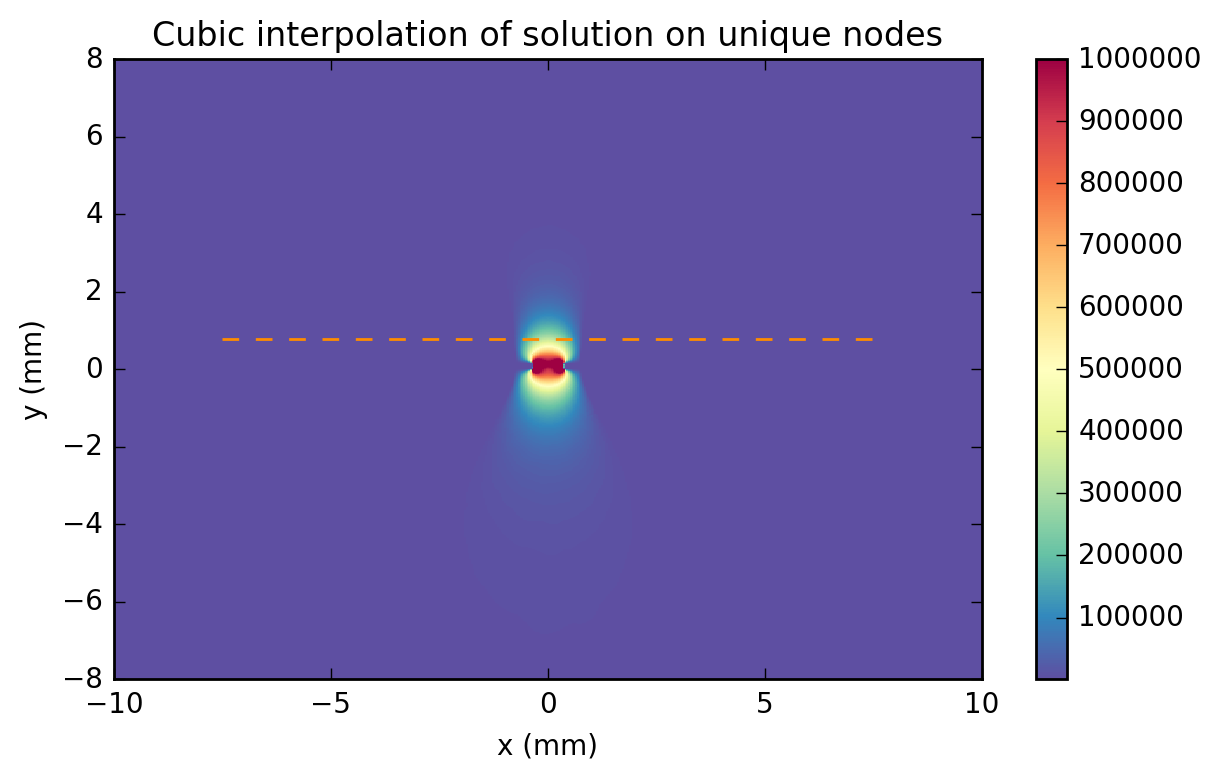

In [16]:
h = 0.78
plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=np.linspace(-10, 10, 501), 
                                                     yeval=np.linspace(-8, 8, 1001), clim=(1e3, 1e6), 
                                                     plot_axes='xy', cmap=plt.cm.Spectral_r)

plt.hlines(h, bounding_box[0], bounding_box[1], linestyles='--', color='darkorange')

The mean electric field over the range (-0.25, 0.25) is 0.3237 V/um.


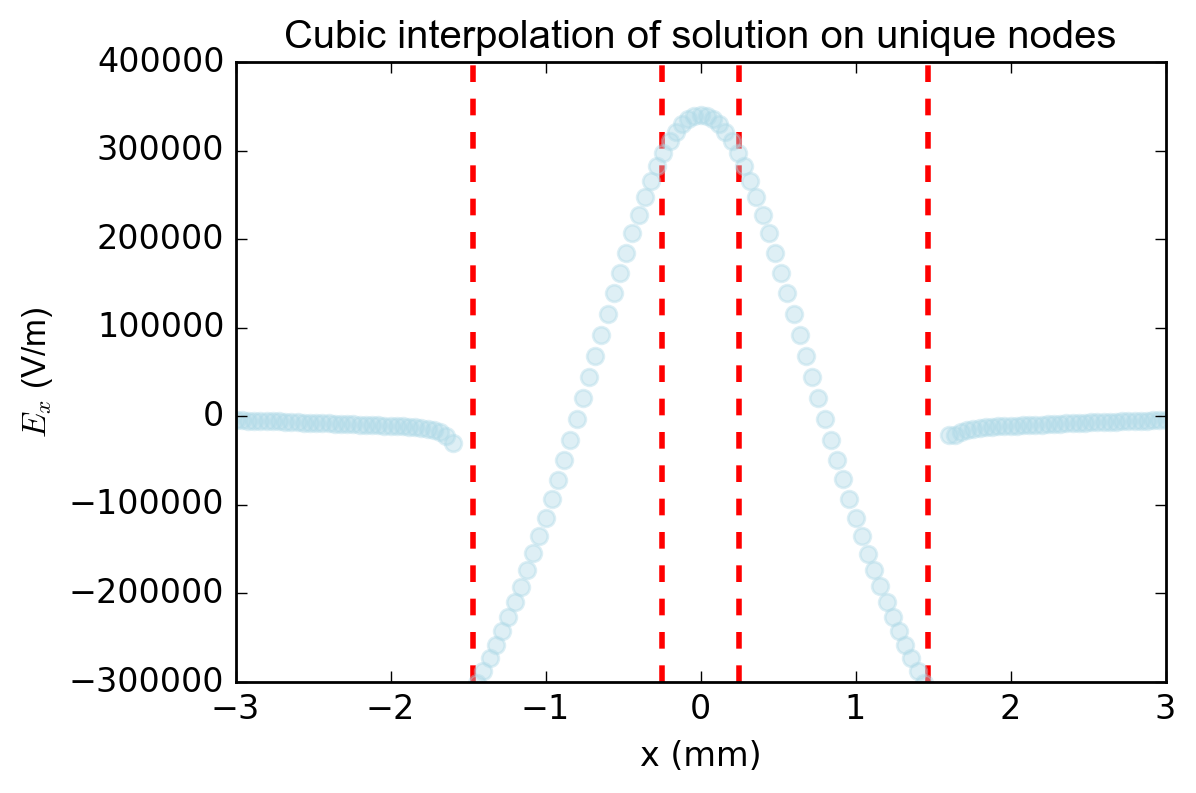

In [19]:
electron_min_x = -0.25 #minimum value of x for the electron
electron_max_x = 0.25 #maximum value of x for the electron

plt.figure(figsize=(6.,4.))
common.configure_axes(12)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=np.linspace(-10, 10, 501), 
                                                     yeval=h, clim=(-3E5, 4E5), linestyle='None', 
                                                     plot_axes='xy', cmap=plt.cm.viridis, 
                                                     **common.plot_opt('lightblue', msize=6))
plt.xlim(-3, 3)
plt.ylabel(r"$E_x$ (V/m)")
plt.vlines((-0.25, 0.25, -1.47, 1.47), -3E5, 4E5, colors='r', lw=2.0, linestyles='--')
ax = plt.gca()
ax.set_axis_bgcolor('none')

meanEx = np.mean(Uinterp[0][np.logical_and(xinterp[0]>electron_min_x , xinterp[0]<electron_max_x)])
print("The mean electric field over the range %s is %.4f V/um." % ( (electron_min_x, electron_max_x), meanEx/1E6))

# Level meter curve

Remember that this data needs to come from the simulation in Maxwell from the RF potential and the differential mode. This means one pin should be on a positive voltage, whereas the other pin has the same voltage, but opposite sign.

A second way to calculate the level shift is to let Maxwell calculate the $E^2$ percentage in the different regions in space. By finding the electric field magnitude in vacuum and in the silicon, it's quite easy to get a feel for what kind of shifts you can expect. Mapping of number of puffs to the fraction of helium filling the vacuum is highly nonlinear though. 

<img src="Maxwell's Calculation.png" width=400>

In [39]:
# Load the data from the dsp file: 
simulation_path=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/V6.3/RFFieldMagE"
#r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"
filename=r"channel_1100nm_L3etchT_450nm.dsp" #r"DifferentialModemagE.dsp"

elements, nodes, elem_solution, bounding_box = import_data.load_dsp(os.path.join(simulation_path, filename))

f0 = 6.45E9
channel_width = 3.5E-6
channel_depth = 1.10E-6
L3_etch_depth = 0.45E-6
pin_thickness = 0.15E-6
between_pins = (-0.35E-6, 0.35E-6)
edge_gaps = [(-1.75E-6, -1.25E-6),(1.25E-6, 1.75E-6)]
eps_silicon = 11.45 # Simulation was done with eps_silicon = 11.45
eps_helium = 1.056
eps_vacuum = 1.000
h =  0.050

L3_etch = True if L3_etch_depth > 0 else False

constants, parameters = reset_constants(verbose=False)
parameters['d0'] = channel_depth # depth of the channel
parameters['w'] = channel_width # width of the channel
parameters['h'] = h #10000 * constants['sigma']/(constants['rho']*constants['g']*parameters['w'])

In [40]:
def channel_bottom(x, L3_etch=True):
    """
    This function should yield the bottom of the channel
    x should be a 1D array in units m, min should not be lower than -channel_width/2. and 
    max should not exceed +channel_width/2.
    """
    bottom = np.zeros(len(x))
    if L3_etch:
        bottom[np.intersect1d(np.where(x>between_pins[0]), 
                          np.where(x<between_pins[1]))] = -L3_etch_depth
        bottom[np.intersect1d(np.where(x>edge_gaps[0][0]), 
                          np.where(x<edge_gaps[0][1]))] = -L3_etch_depth
        bottom[np.intersect1d(np.where(x>edge_gaps[1][0]), 
                          np.where(x<edge_gaps[1][1]))] = -L3_etch_depth
    return bottom

def helium_shift(p_He, p_vac_tot, p_Si):
    # The numerator has the fraction of the efield that is in the helium. Whatever part of the Efield is in the
    # helium cannot be in the vacuum, so we subtract it. The denominator contains the sum of all the regions, 
    # without any dielectric constants. We don't include the _all_helium because we would count it twice (it is 
    # already in the _all_vacuum suffix)
    #enew = ((p_vac_tot-Esquared_all_helium) + 1.056*Esquared_all_helium + 11.45*Esquared_all_silicon)\
    #/(Esquared_all_silicon + Esquared_all_vacuum)
    #eold = enew[0]
    eps_ratio = (p_Si*eps_silicon + p_vac_tot*eps_vacuum + p_He*(eps_helium-eps_vacuum))/\
    (p_Si*eps_silicon + p_vac_tot*eps_vacuum)
    return -f0 * (1-eps_ratio**(-0.5))

In [41]:
xeval = anneal.construct_symmetric_y(-5, 501)
yeval = np.linspace(-5, 5, 1001)

#plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, 
                                                     yeval=yeval, clim=None, plot_mesh=False, plot_data=False,
                                                     plot_axes='xy', cmap=plt.cm.viridis)

# Mirror around the y-axis
ysize, xsize = np.shape(Uinterp)
Uinterp_symmetric = np.zeros((ysize, 2*xsize))
Uinterp_symmetric[:, :xsize] = Uinterp
Uinterp_symmetric[:, xsize:] = Uinterp[:, ::-1]

x_symmetric = np.zeros((ysize, 2*xsize))
x_symmetric[:, :xsize] = xinterp
x_symmetric[:, xsize:] = -xinterp[:, ::-1]

y_symmetric = np.zeros((ysize, 2*xsize))
y_symmetric[:, :xsize] = yinterp
y_symmetric[:, xsize:] = yinterp

Esqrd = Uinterp_symmetric**2

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


(-5.0, 5.0)

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


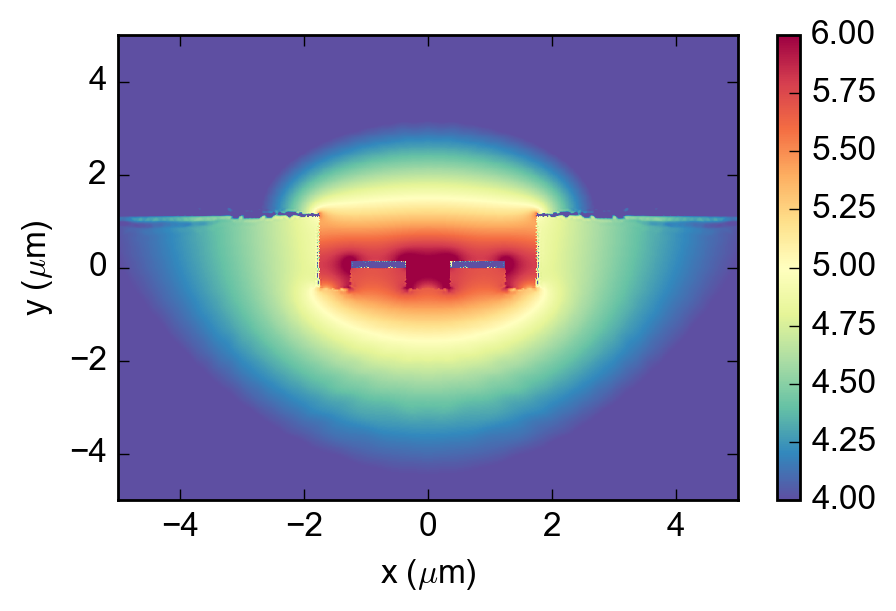

In [42]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.pcolormesh(x_symmetric, y_symmetric, np.log10(Uinterp_symmetric), cmap=plt.cm.Spectral_r, vmin=4, vmax=6)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
plt.ylim(np.min(y_symmetric), np.max(y_symmetric))

In [43]:
def z_theory(x, h):
    return constants['rho']*constants['g']*h/(2*constants['sigma']) * \
(x**2 - (parameters['w']/2.)**2) + parameters['d0']

def get_proportions(h):
    parameters['h'] = h
    # Define the start and stop integration of the channel
    xstart_idx = common.find_nearest(x_symmetric[0, :]*1E-6, -channel_width/2.)
    xstop_idx = common.find_nearest(x_symmetric[0, :]*1E-6, +channel_width/2.)
    dx = np.abs((x_symmetric[0, 1] - x_symmetric[0, 0])) * 1E-6
    dy = np.abs((y_symmetric[1, 0] - y_symmetric[0, 0])) * 1E-6

    # Define the start and stop of the integration outside the channel
    ywall_idx = common.find_nearest(y_symmetric[:, 0]*1E-6, channel_depth)

    plot_x = x_symmetric[0, xstart_idx:xstop_idx] * 1E-6
    p_He, p_vac_tot, p_Si = 0, 0, 0
    z0 = channel_bottom(plot_x, L3_etch=L3_etch)
    z1 = z_theory(plot_x, h) #z(constants, parameters, channel_width/2. + plot_x)
    for k, xidx in enumerate(range(xstart_idx, xstop_idx)):
        zstart = common.find_nearest(y_symmetric[:, 0]*1E-6, z0[k])
        zstop = common.find_nearest(y_symmetric[:, 0]*1E-6, z1[k])
        p_He += np.sum(Esqrd[zstart:zstop, xidx]) * dx * dy
        p_vac_tot += np.sum(Esqrd[zstart:, xidx]) * dx * dy
        p_Si += np.sum(Esqrd[:zstart, xidx]) * dx * dy

    p_Si += (np.sum(Esqrd[:ywall_idx,:xstart_idx]) + np.sum(Esqrd[:ywall_idx,xstop_idx:])) * dx * dy
    p_vac_tot += (np.sum(Esqrd[ywall_idx:, :xstart_idx]) + np.sum(Esqrd[ywall_idx:, xstop_idx:])) * dx * dy

    return p_He, p_vac_tot, p_Si

p_He, p_vac_tot, p_Si = get_proportions(h)
helium_shift(p_vac_tot, p_vac_tot, p_Si)/1E6

-47.886732587616194

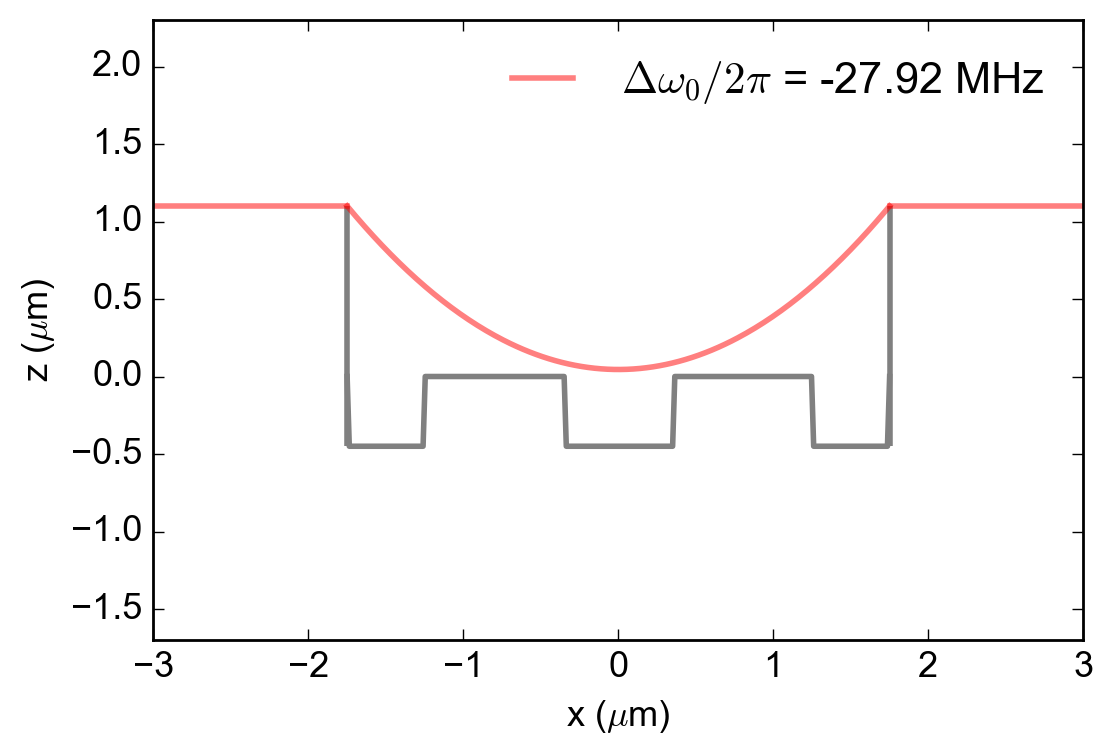

In [44]:
colors = ['red', 'gray']
props = {'alpha' : 0.5, 'lw' : 2.0}
plot_x = np.linspace(-parameters['w']/2., parameters['w']/2., 251)

fig=plt.figure(figsize=(6.,4.))
common.configure_axes(13)

def vary_height_and_plot(h=5E-3):
    p_He, p_vac_tot, p_Si = get_proportions(h)
    plt.plot(plot_x*1E6, z_theory(plot_x, h)*1E6, color=colors[0], 
         label="$\Delta \omega_0/2\pi$ = %.2f MHz"%(helium_shift(p_He, p_vac_tot, p_Si)/1E6), **props)
    plt.plot(plot_x*1E6, channel_bottom(plot_x, L3_etch=L3_etch)*1E6, color=colors[1], lw=2.0)
    plt.plot(np.linspace(-3, -channel_width/2. * 1E6, 2), 1E6 *channel_depth * np.ones(2), 
             color=colors[0], **props)
    plt.plot(np.linspace(channel_width/2. * 1E6, 3, 2) , 1E6 *channel_depth * np.ones(2), 
             color=colors[0], **props)
    plt.vlines([-channel_width/2.*1E6, +channel_width/2.*1E6], -L3_etch_depth*1E6, 
               channel_depth*1E6, colors=colors[1], lw=2.0)
    plt.axes().set_aspect('equal', 'datalim')
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("z ($\mu$m)")
    plt.legend(loc=0, frameon=False)

interact(vary_height_and_plot, h=(0E-3, 250E-3, 0.01E-3));


print("Maximum shift possible is %.2f MHz"%(helium_shift(p_vac_tot, p_vac_tot, p_Si)/1E6))

# Filling behavior

In [3]:
def draw_channel(parameters, x):
    y = 1E6*parameters['d0']*ones(len(x))
    plt.fill_between(x, y, y2=0, alpha=0.2, color='gray', lw=0)

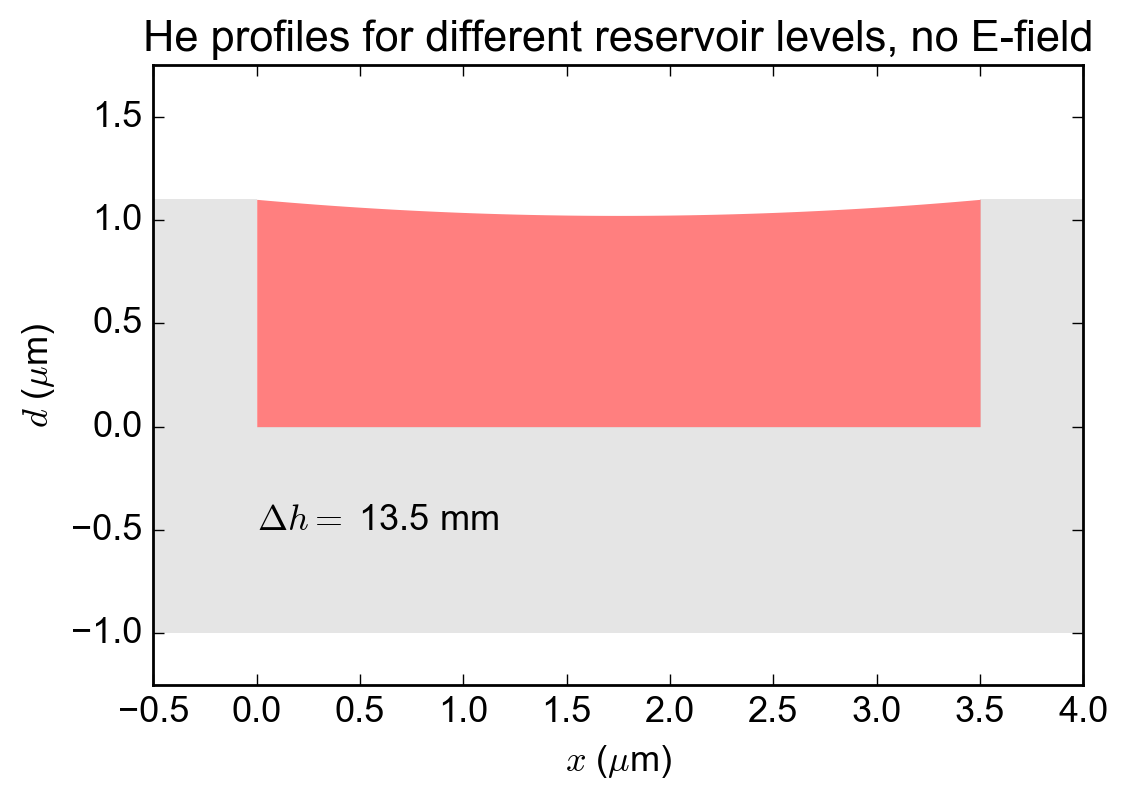

In [28]:
constants, parameters = reset_constants(verbose=False)
parameters['d0'] = 1.1E-6 # depth of the channel
parameters['w'] = 3.5E-6 # width of the channel

def z_theory(x, h):
    return constants['rho']*constants['g']*h/(2*constants['sigma']) * (x**2 - (parameters['w']/2.)**2) + parameters['d0']

x = linspace(0, parameters['w'], 1E4)
hmin = constants['sigma']/(constants['rho']*constants['g']*0.5*parameters['w'])
hmax = constants['sigma']/(constants['rho']*constants['g']*1000*parameters['w'])

xmin = -0.5
xmax = parameters['w']*1E6+0.5

fig=plt.figure(figsize=(6.,4.))
common.configure_axes(13)

def vary_height_and_plot(h=5E-3):
    
    x_plot = np.linspace(-parameters['w']/2., parameters['w']/2., 101)
    
    parameters['h'] = h
    draw_channel(parameters, [-5, 0])
    draw_channel(parameters, [parameters['w']*1E6, parameters['w']*1E6+5])
    plt.fill_between(x*1E6, 1E6*z_theory(x-parameters['w']/2., parameters['h']), y2=0, 
                     color='red', alpha=0.5, lw=0.0)
    plt.xlabel('$x$ ($\mu$m)')
    plt.ylabel('$d$ ($\mu$m)')
    plt.xlim(xmin, xmax)
    plt.title("He profiles for different reservoir levels, no E-field")
    plt.fill_between([-0.5, 6], [-1.0, -1.0], y2=0, alpha=0.2, color='gray', lw=0)
    plt.axes().set_aspect('equal', 'datalim')
    plt.text(0, -0.5, "$\Delta h = $ {:.1f} mm".format(h*1E3))
    ax = plt.gca()
    ax.set_axis_bgcolor('none')
    #plt.plot(x_plot*1E6 + parameters['w']/2.*1E6, z_theory(x_plot, h)*1E6)
    
interact(vary_height_and_plot, h=(0E-3, 250E-3, 0.01E-3));

print_constants_parameters(constants, parameters)


# Resonator DC bias potential

In [51]:
# Load the data from the dsp file: 
path=r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/V6.3/DCBiasPotentials/channel_1100nm_L3_450nm.dsp"
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160530 - M016v5 resonator xz cut magE.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ====================  =====================
Parameter           Value                   Std
===========  ====================  =====================
a0           -0.5733422969887814   9.020950750069621e-08
a1           0.10114783438818568   9.119414632962845e-06
a2           0.046743817616665795  0.0001644409481707123
===========  ====================  =====================
f = 30.018 +/- 0.001 GHz


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


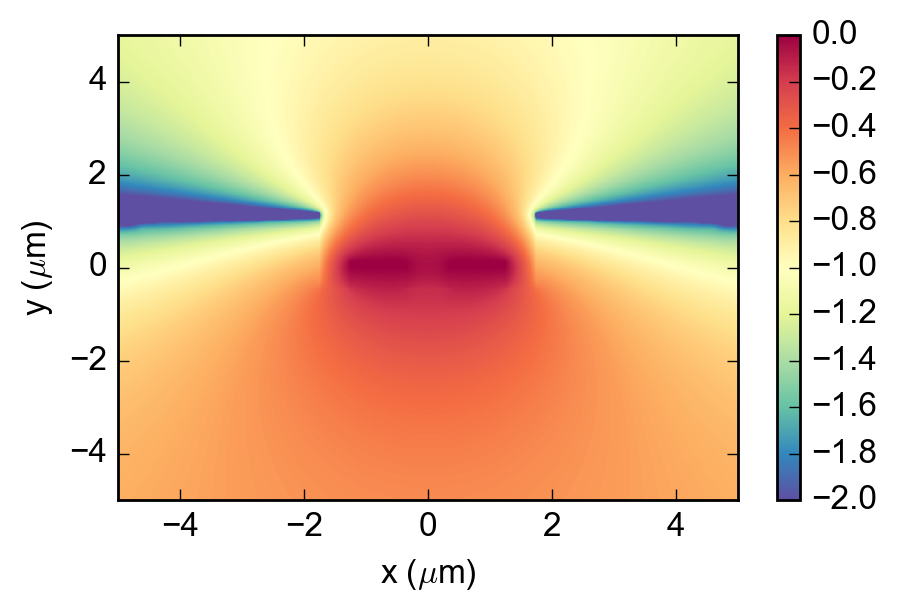

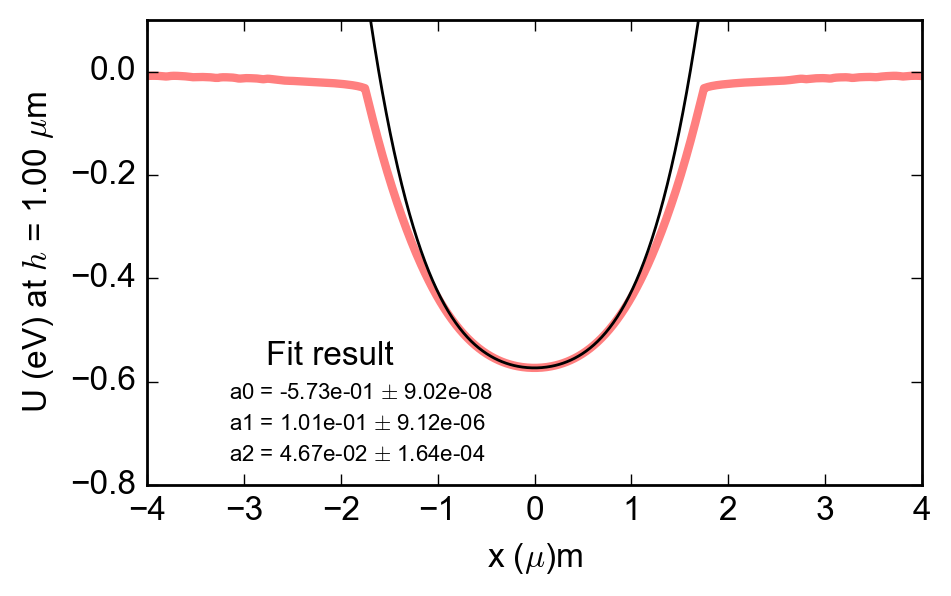

In [61]:
h = 1
fitdomain=(-0.25, 0.25)

xeval = anneal.construct_symmetric_y(-5, 501)
yeval = np.linspace(-5, 5, 1001)

plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, 
                                                     yeval=yeval, clim=None, plot_mesh=False, plot_data=False,
                                                     plot_axes='xy', cmap=plt.cm.viridis)

# Mirror around the y-axis
ysize, xsize = np.shape(Uinterp)
Uinterp_symmetric = np.zeros((ysize, 2*xsize))
Uinterp_symmetric[:, :xsize] = Uinterp
Uinterp_symmetric[:, xsize:] = Uinterp[:, ::-1]

x_symmetric = np.zeros((ysize, 2*xsize))
x_symmetric[:, :xsize] = xinterp
x_symmetric[:, xsize:] = -xinterp[:, ::-1]

y_symmetric = np.zeros((ysize, 2*xsize))
y_symmetric[:, :xsize] = yinterp
y_symmetric[:, xsize:] = yinterp

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.pcolormesh(x_symmetric, y_symmetric, np.log10(Uinterp_symmetric), cmap=plt.cm.Spectral_r, vmin=-2, vmax=0)
plt.colorbar()
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
plt.ylim(np.min(y_symmetric), np.max(y_symmetric))

index = common.find_nearest(y_symmetric[:, 0], h)
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_symmetric[index, :], -Uinterp_symmetric[index, :], '-', color='r', alpha=0.5, lw=3)
ax = plt.gca()
ax.set_axis_bgcolor('none')
fr, ferr = kfit.fit_poly(x_symmetric[index, :], -Uinterp_symmetric[index, :], mode='even', 
                         fitparams=[0, 0.01, 0.01], domain=fitdomain)
plt.plot(x_symmetric[index, :], kfit.polyfunc_even(x_symmetric[index, :], *fr), color='k')
plt.ylim(-0.8, 0.1)
plt.xlim(-4, 4)

t = trap_analysis.TrapSolver()
t.get_electron_frequency([fr[0], -fr[1]], [ferr[0], ferr[1]]);

plt.xlabel("x ($\mu$)m")
plt.ylabel("U (eV) at $h$ = %.2f $\mu$m"%(h))

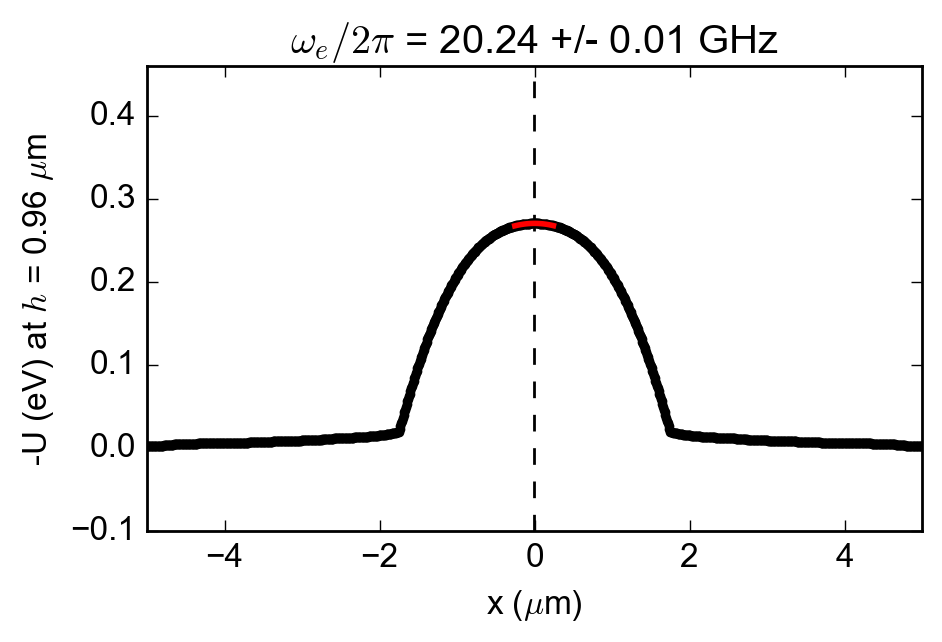

In [107]:
t = trap_analysis.TrapSolver()

def plot_resonator_potential(resonator_voltage=0.6):
    plt.figure(figsize=(5.,3.))
    voltage = resonator_voltage
    V = voltage*Uinterp_symmetric[index,:]
    X = x_symmetric[index,:]#xinterp[0]*1E3
    Y = y_symmetric[:,index]#yinterp[0]*1E3
    
    plt.plot(X, V)
    plt.xlim(min(X), max(X))
    plt.title('$h$ = %.2f $\mu$m, Feature size: 1 $\mu$m'%(h))
  
    if voltage >= 0:
        try:
            fr, ferr = t.fit_electron_potential(X, V, fitdomain=(X[np.argmax(V)]-0.25, 
                                                                 X[np.argmax(V)]+0.25), do_plot=True)
            f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
        except:
            f0, sigmaf0 = np.nan, np.nan
        plt.ylim(-0.1, voltage)
    else:
        f0, sigmaf0 = np.nan, np.nan
        plt.plot(X, V, '.k')
        plt.ylim(voltage, -voltage)
        
    plt.vlines(X[np.argmax(V)], ymin=-0.1, ymax=3.0, colors='k', linestyles='--')
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("-U (eV) at $h$ = %.2f $\mu$m"%(h))
    plt.title("$\omega_e/2\pi$ = {:.2f} +/- {:.2f} GHz".format(f0/1E9, sigmaf0/1E9))
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    ax = plt.gca()
    ax.set_axis_bgcolor('none')
    #plt.ylim(-1, ymax)
    
interact(plot_resonator_potential, resonator_voltage=(0.01, 3, 0.05));

## Nonlinearity as a function of helium height

(0.80000000000000004, 1.1000000000000001)

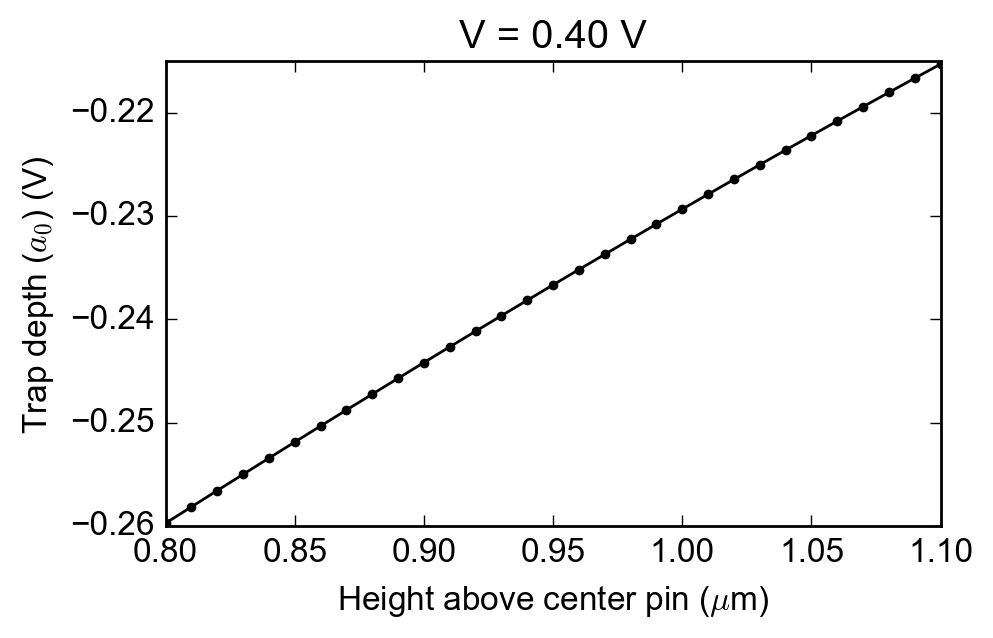

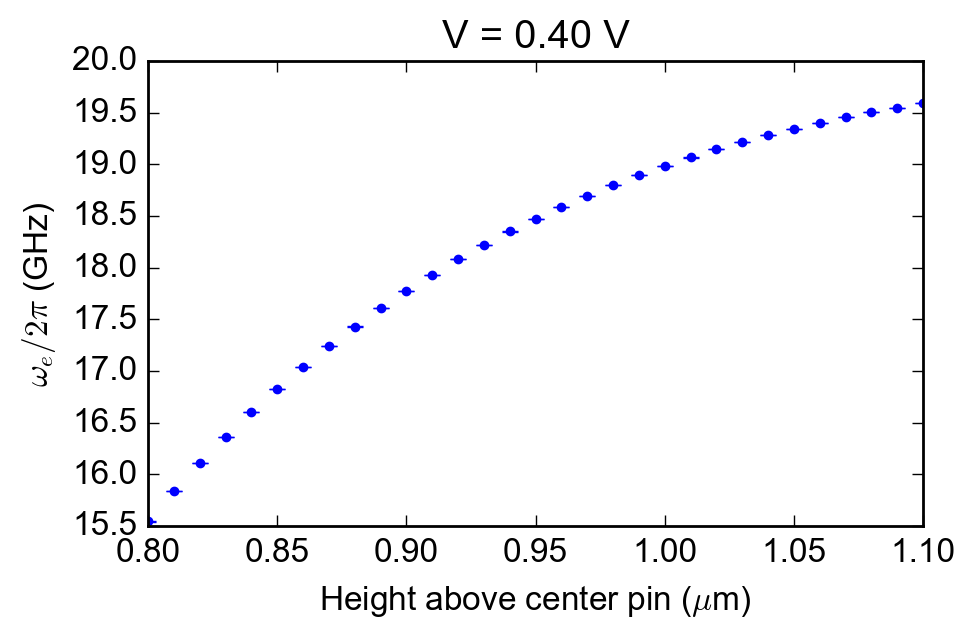

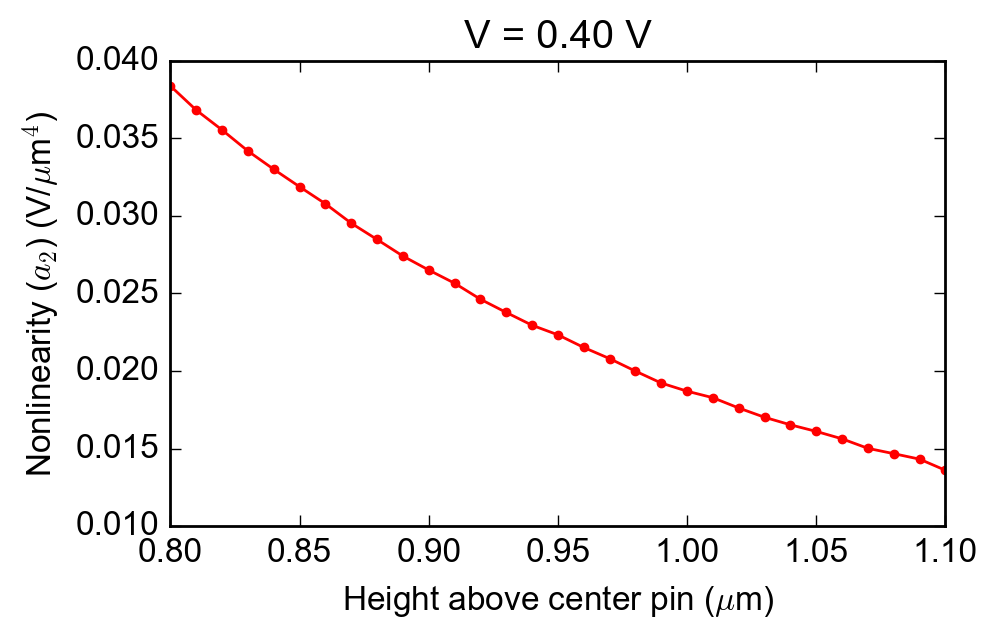

In [113]:
hs = linspace(0.8, 1.1, 31)
Voi = 0.4
f_e = list()
fitresults = list()
for H in hs:
    domain=(-0.5, 0.5)
    index = common.find_nearest(y_symmetric[:, 0], H)
    fr, ferr = kfit.fit_poly(x_symmetric[index, :], -Voi * Uinterp_symmetric[index, :], mode='even', 
                         fitparams=[0, 0.01, 0.01], domain=fitdomain, verbose=False)

    t = trap_analysis.TrapSolver()
    f_e.append(t.get_electron_frequency([fr[0], -fr[1]], [ferr[0], ferr[1]], verbose=False))
    fitresults.append(fr)
    
fitresults = np.array(fitresults)
plt.figure(figsize=(5.,3.))
plt.title("V = %.2f V"%(Voi))
plt.plot(hs, fitresults[:,0], '.-k')
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("Trap depth ($a_0$) (V)")
plt.xlim(hs[0], hs[-1])

plt.figure(figsize=(5.,3.))
plt.title("V = %.2f V"%(Voi))
plt.errorbar(hs, np.array(f_e)[:,0]/1E9, yerr=np.array(f_e)[:,1]/1E9, fmt='.')
plt.xlim(hs[0], hs[-1])
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("$\omega_e/2\pi$ (GHz)")

plt.figure(figsize=(5.,3.))
plt.title("V = %.2f V"%(Voi))
plt.plot(hs, fitresults[:,2], '.-r')
plt.xlabel("Height above center pin ($\mu$m)")
plt.ylabel("Nonlinearity ($a_2$) (V/$\mu$m$^4$)")
plt.xlim(hs[0], hs[-1])

# Single electron interacting with the resonator

100%|██████████| 1001/1001 [00:03<00:00, 316.82it/s]


(1001, 2)


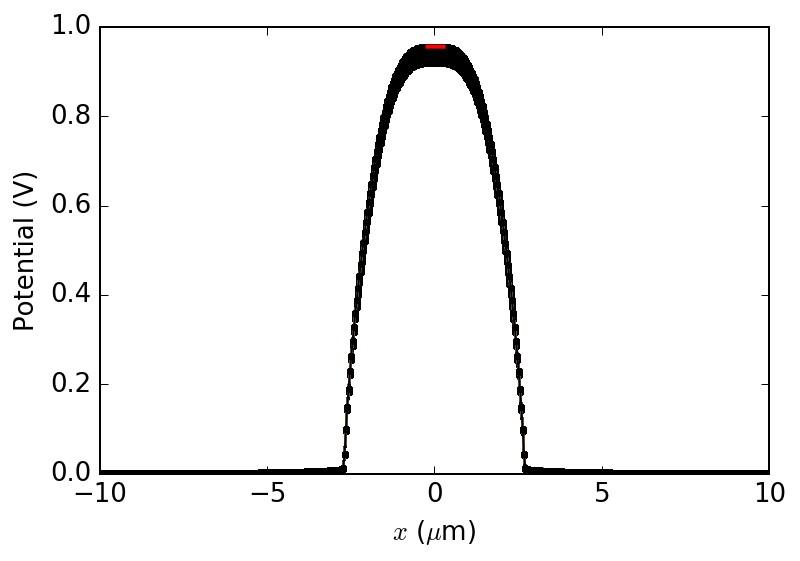

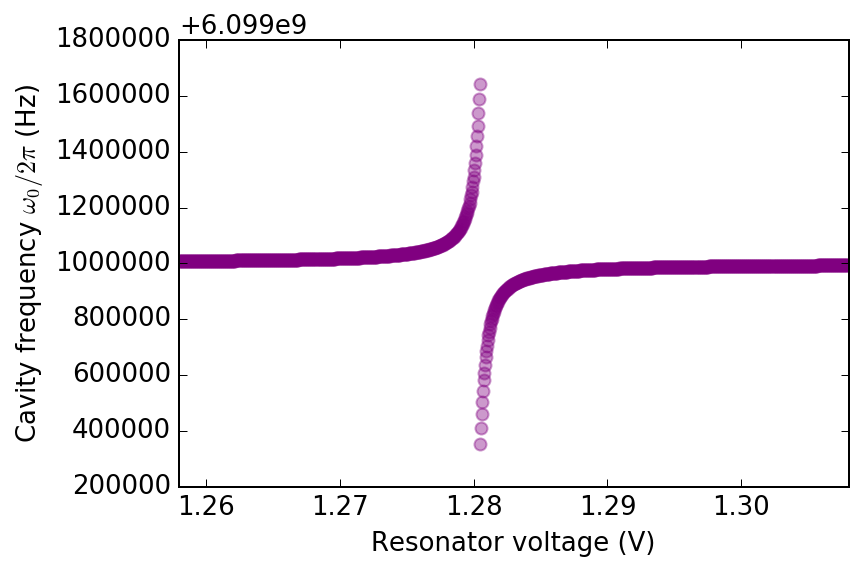

In [164]:
t = trap_analysis.TrapSolver()

#:param alpha: Quadratic component of the DC trapping potential in V/um**2
#:param beta: Linear component of the resonator differential mode potential in V/um.
#:param f0: Bare cavity frequency, without electrons, in Hz
#:param P: Power of the input drive in dBm
#:param Q: Q of the microwave cavity
#:return: 2 eigenvalues, one of which is the cavity frequency and one the electron frequency in Hz.

center = 1.283
span = 0.05

resVs = np.linspace(center-span/2., center+span/2., 1001)
resfreqs = list()
plt.figure(figsize=(6.,4.))

for voltage in tqdm(resVs):
    V = voltage*Uinterp[0]
    X = xinterp[0]*1E3
    Y = yinterp[0]*1E3

    plt.plot(X, V)
    plt.xlim(min(X), max(X))

    fr, ferr = t.fit_electron_potential(X, V, fitdomain=(X[np.argmax(V)]-0.25, X[np.argmax(V)]+0.25), do_plot=True)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    
    alpha = -fr[1]
    beta = 0.29 #V/um, from the top of this notebook
    f0 = 6.10E9
    
    # Both changing the power and the Q of the resonator leads to a stronger signal
    Q = 1E4
    P = -50

    f1, f2 = t.get_eigenfreqencies(alpha, beta, f0, P, Q)
    resfreqs.append([f1, f2])

print np.shape(np.array(resfreqs)) 
resfreqs = np.array(resfreqs)

plt.figure(figsize=(6.,4.))
plt.plot(resVs, resfreqs[:,0], linestyle='None', **common.plot_opt('purple', msize=6))
plt.xlim(np.min(resVs), np.max(resVs));
plt.xlabel("Resonator voltage (V)")
plt.ylabel("Cavity frequency $\omega_0/2\pi$ (Hz)")
ax = plt.gca()
ax.set_axis_bgcolor('none')

# Greater trap area simulation

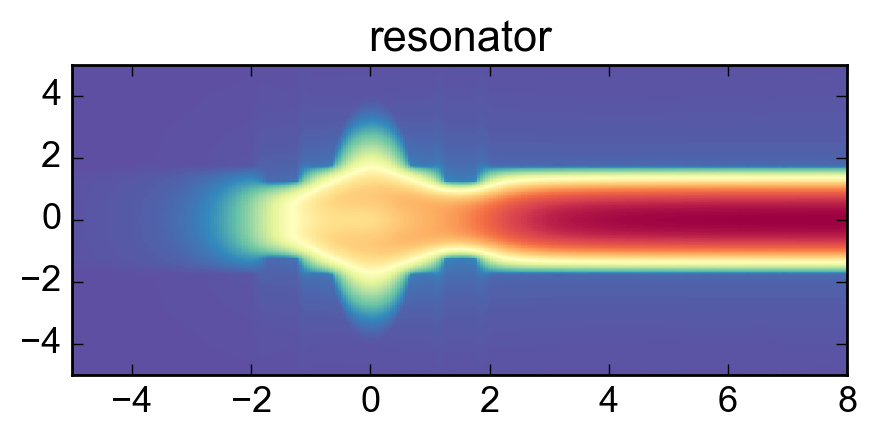

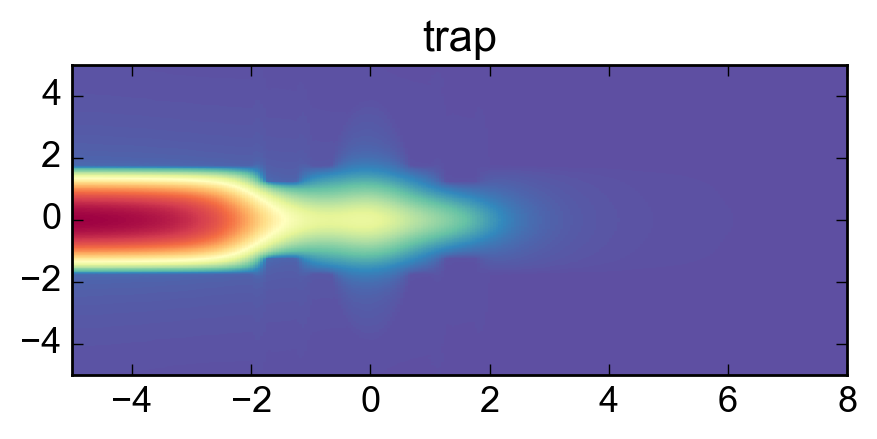

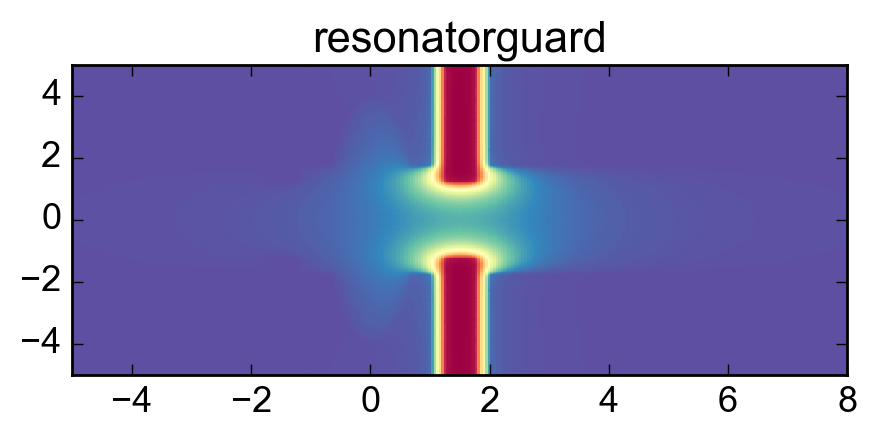

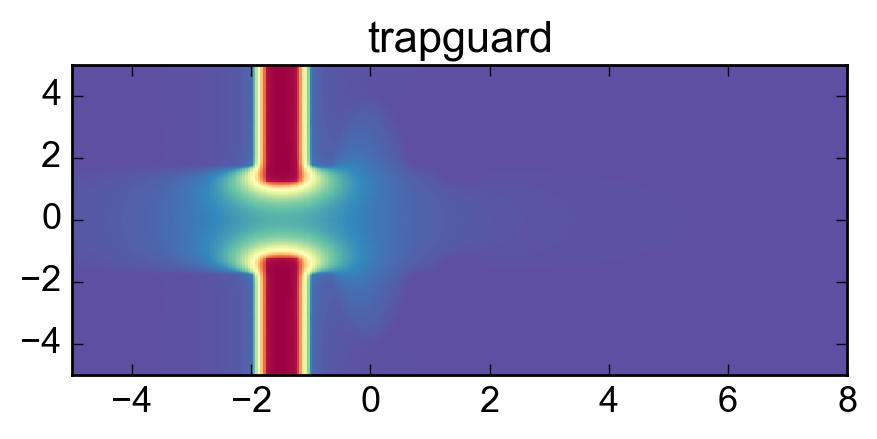

In [3]:
# Evaluate all files in the range
yeval = anneal.construct_symmetric_y(-5, 201)
xeval = np.linspace(-5, 8, 301)

datafiles = ["Resonator.dsp",
             "Trap.dsp",
             "ResonatorGuard.dsp",
             "TrapGuard.dsp"]
output = list()
names = ['resonator', 'trap', 'resonatorguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(
        os.path.join('/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, 
                                                                     nodes, 
                                                                     elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter

    plt.figure(figsize=(7.,4.))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, 
                                                                  xeval=xeval, 
                                                                  yeval=yeval, 
                                                                  clim=None, 
                                                                  plot_mesh=False, 
                                                                  plot_data=False,
                                                                  plot_axes='xy', 
                                                                  cmap=plt.cm.viridis)

    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2 * ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:, :] = Uinterp[::-1, :]

    y_symmetric = np.zeros((2 * ysize, xsize))
    y_symmetric[:ysize, :] = yinterp
    y_symmetric[ysize:, :] = -yinterp[::-1, :]

    x_symmetric = np.zeros((2 * ysize, xsize))
    x_symmetric[:ysize, :] = xinterp
    x_symmetric[ysize:, :] = xinterp
    
    output.append({'name' : name, 
                   'V' : np.array(Uinterp_symmetric, dtype=np.float64),
                   'x' : np.array(x_symmetric, dtype=np.float64), 
                   'y' : np.array(y_symmetric, dtype=np.float64)})
    
for k in range(4):
    plt.figure(figsize=(5.,2.));
    plt.pcolormesh(output[k]['x'], output[k]['y'], output[k]['V'], cmap=plt.cm.Spectral_r)
    plt.title(output[k]["name"])
    plt.xlim(np.min(output[k]['x']), np.max(output[k]['x']))
    plt.ylim(np.min(output[k]['y']), np.max(output[k]['y']))

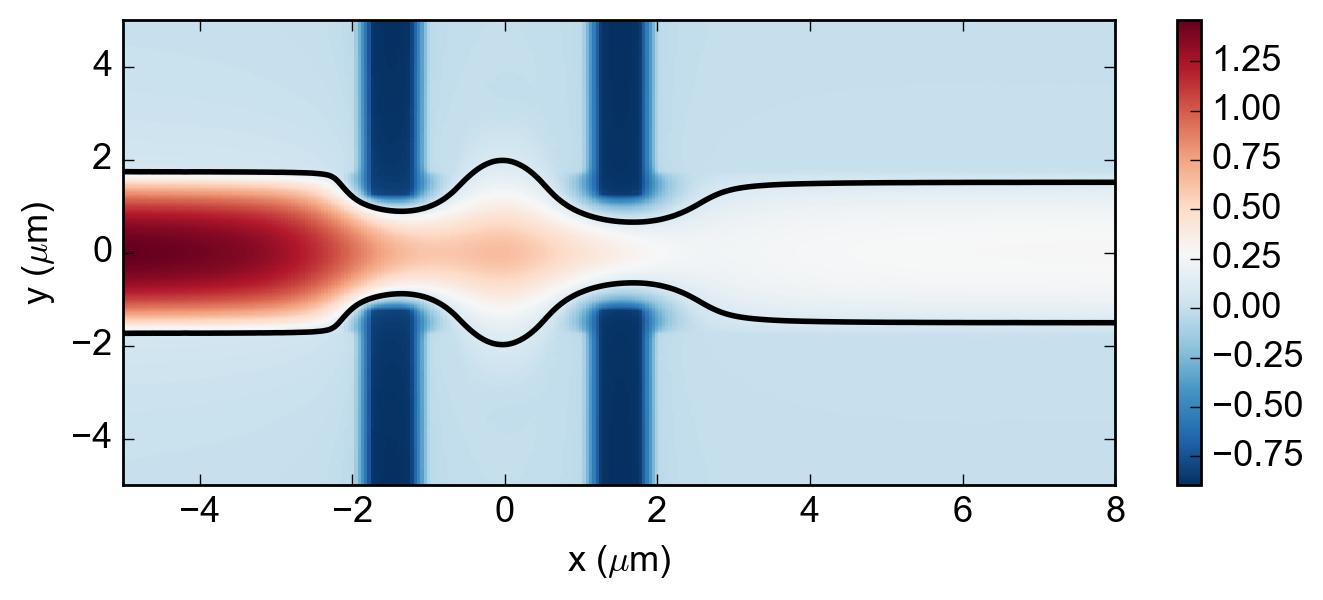

In [136]:
t = trap_analysis.TrapSolver()
#x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
x = output[0]['x']
y = output[0]['y']

import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8., 3.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.5, trap=+2.5, resonatorguard=-1.0, trapguard=-1.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, chemical_potential=0.1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, 
                            auto_scale=True):
    
    fig = plt.figure()
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
        
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']
    
    #combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    
    if not auto_scale:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    
    ymin, ymax = np.min(y), np.max(y)
    
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("y ($\mu$m)")
    plt.colorbar()
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(ymin, ymax)
    
    levels = np.array([chemical_potential])
    CS = plt.contour(x, y, combined_potential, levels, origin='lower', linewidths=2, colors='k')
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
    #plt.text(2, ymin + 0.2*(ymax-ymin), biasVoltages)
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), chemical_potential=(-5, 5, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, auto_scale=True);

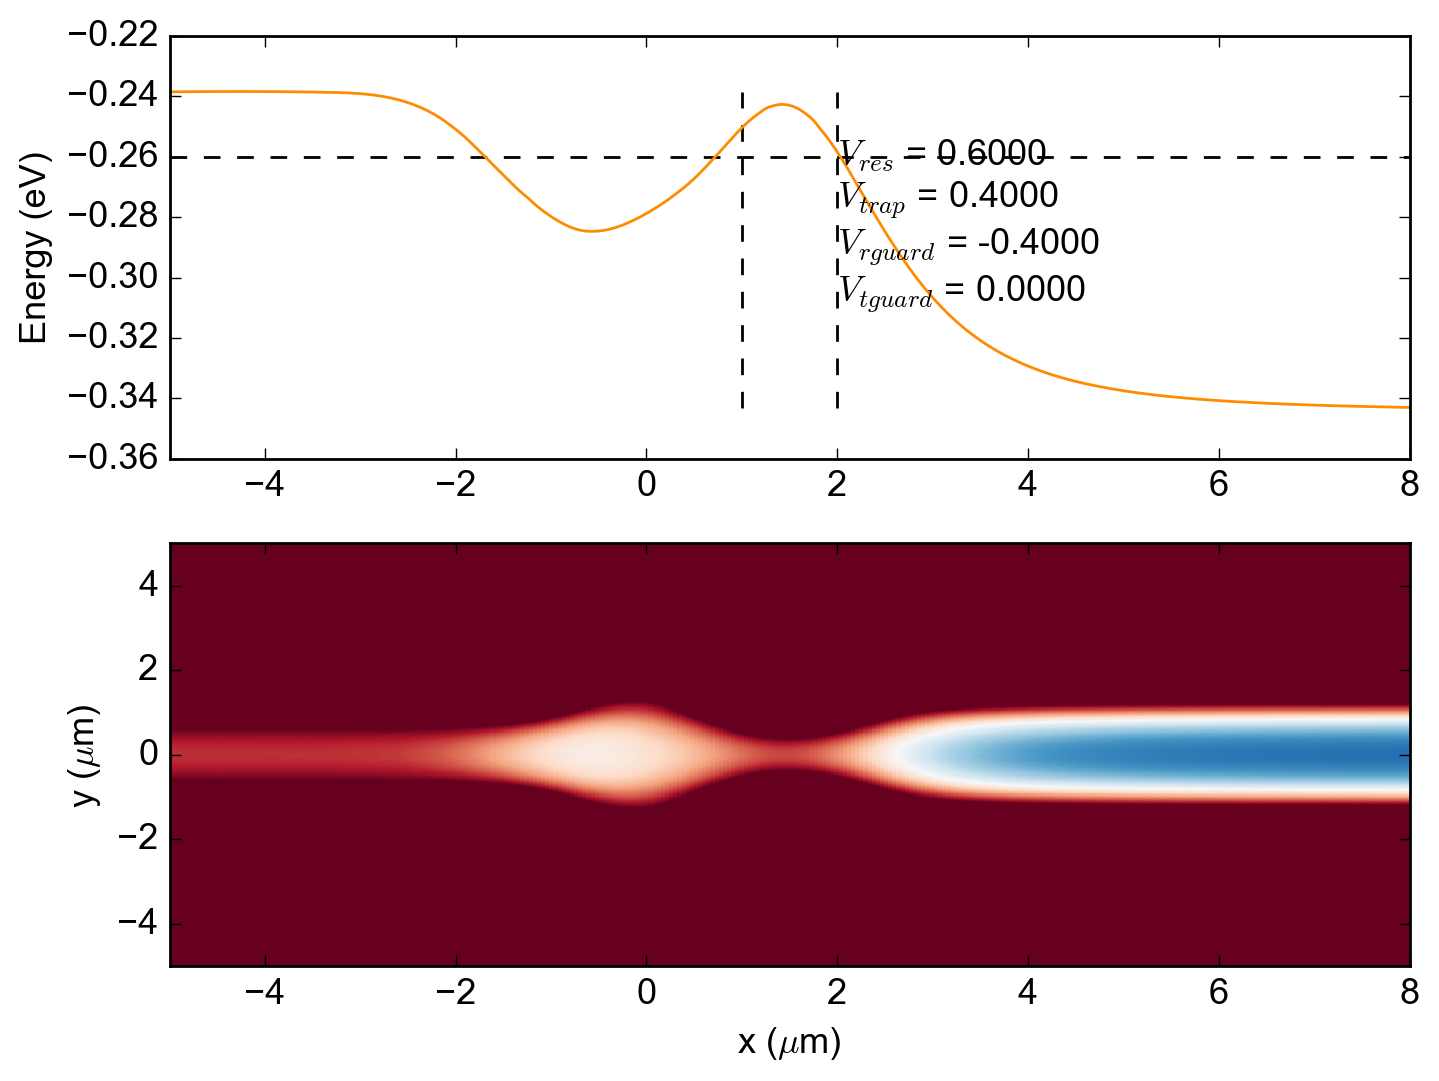

In [4]:
t = trap_analysis.TrapSolver()
#x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
x = output[0]['x']
y = output[0]['y']

import matplotlib as mpl
# common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (8.,3.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.60, trap=+0.40, resonatorguard=-0.40, centerguard=0.00, 
                            trapguard=0.00, scaling=0.0, 
                            color_minimum=-0.10, color_maximum=0.10, chemical_potential=-0.26, 
                            trap_resg_locked=False, left_right_guard_locked=False, 
                            auto_scale=False):
    
    fig = plt.figure(figsize=(8.,6.))
    plt.subplot(211)
    
    if trap_resg_locked:
        resonatorguard = 1/0.25*(trap - 0.30)
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']
    
    TS = anneal.TrapAreaSolver(x[0,:], y[:,0], -combined_potential.T, smoothing=0.01)
    
    #print(np.shape(x), np.shape(y), np.shape(combined_potential))
    
    #combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    centeridx = int(np.shape(y)[0]/2)
    plt.plot(x[0, :], TS.V(x[0,:], 0), color='darkorange')
    plt.hlines(chemical_potential, np.min(x[0,:]), np.max(x[0,:]), linestyles='--')
    #plt.plot(x[centeridx, :], -combined_potential[centeridx, :], color='darkorange')
    plt.gca().set_axis_bgcolor('none')
        
    ymin, ymax = np.min(-combined_potential[centeridx,:]), np.max(-combined_potential[centeridx,:])
    
    #plt.xlabel("x ($\mu$m)")
    plt.ylabel("Energy (eV)")
    plt.xlim(np.min(x), np.max(x))
    if not auto_scale:
        plt.ylim(color_minimum, color_maximum)
    else:
        color_minimum, color_maximum = plt.ylim()
        #plt.ylim(-0.7, -0.65)
        
    biasVoltages = "$V_{res}$ = %.4f\n$V_{trap}$ = %.4f\n$V_{rguard}$ = %.4f\n$V_{tguard}$ = %.4f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
    plt.text(2, ymin + 0.2*(ymax-ymin), biasVoltages)
    plt.vlines([1.0, 2.0], ymin, ymax, linestyles='--', color='k')
    
    plt.subplot(212)
    plt.pcolormesh(x, y, -combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("y ($\mu$m)")
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(np.min(y), np.max(y))
    
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5,5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         chemical_potential=(-5, 5, 0.05), color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), 
         trap_resg_locked=False, left_right_guard_locked=False, auto_scale=True);

# Trap area simulation

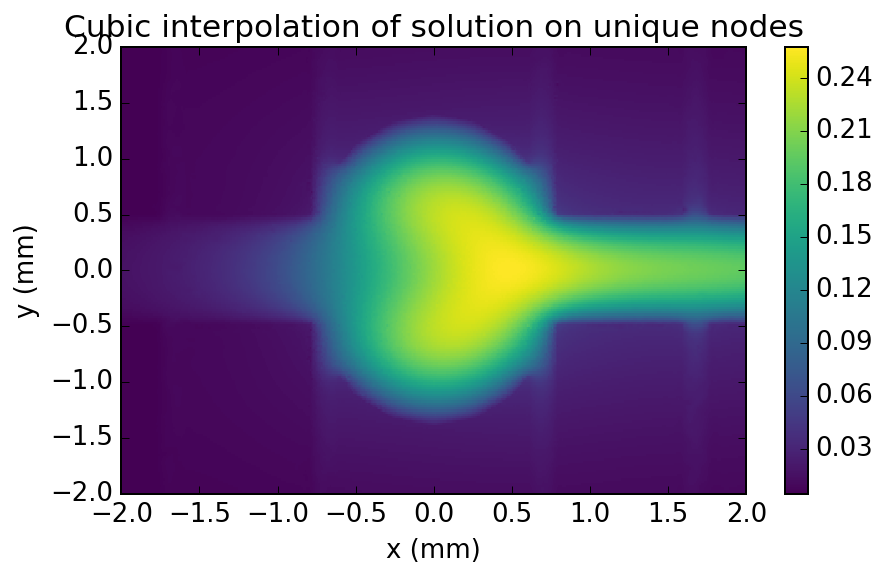

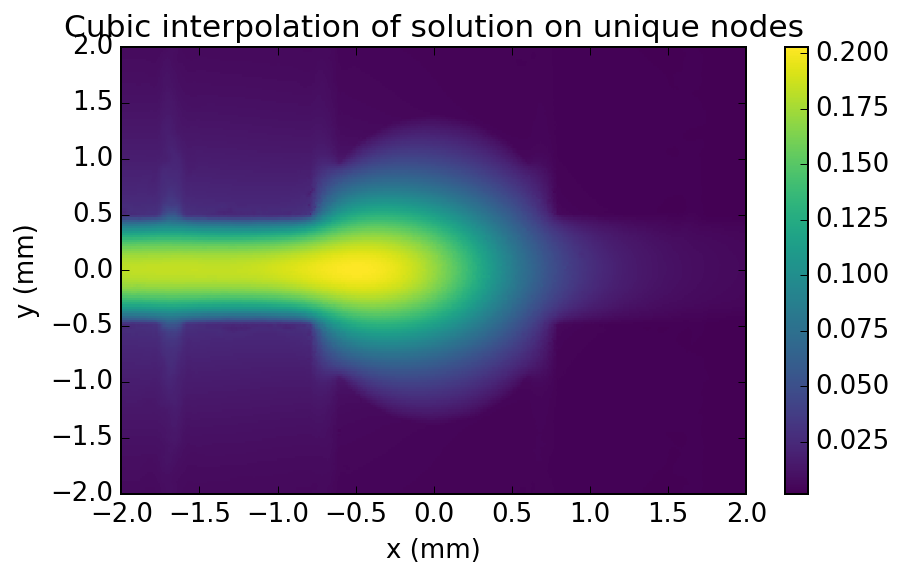

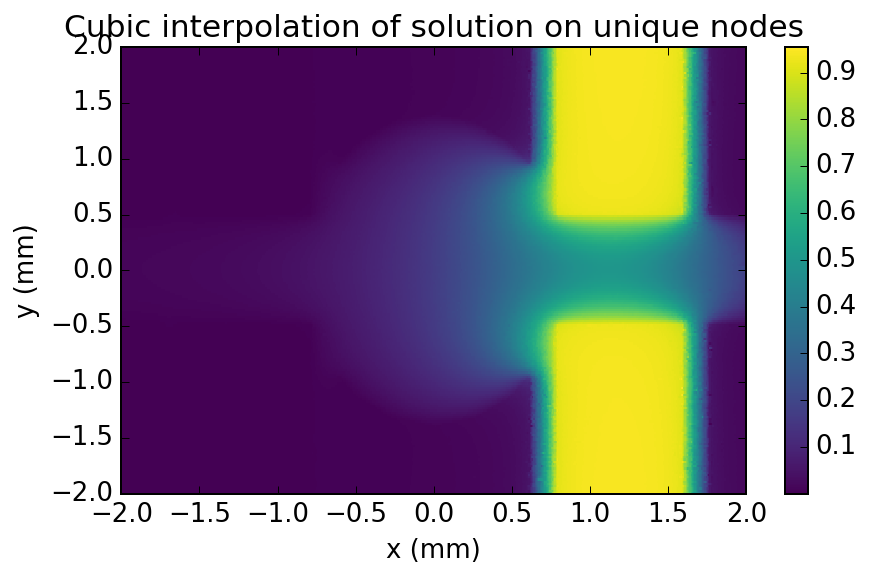

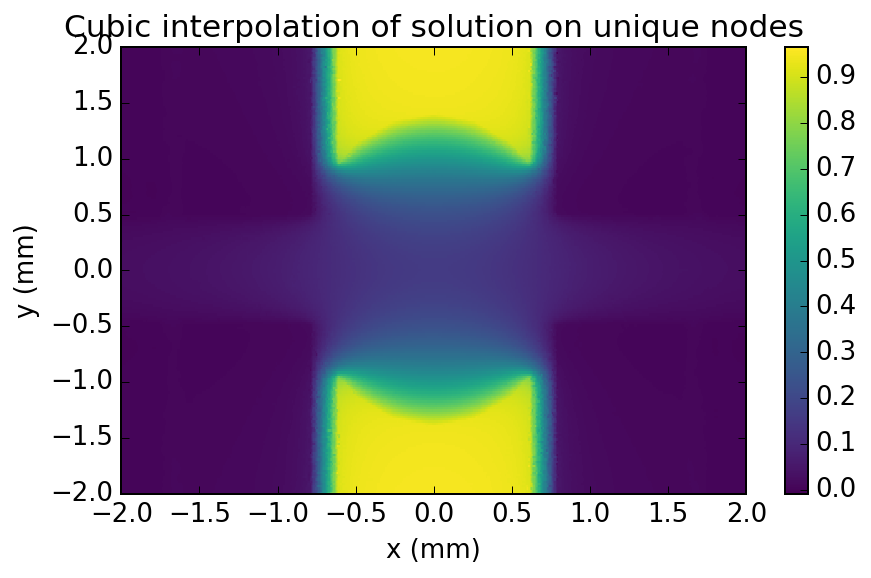

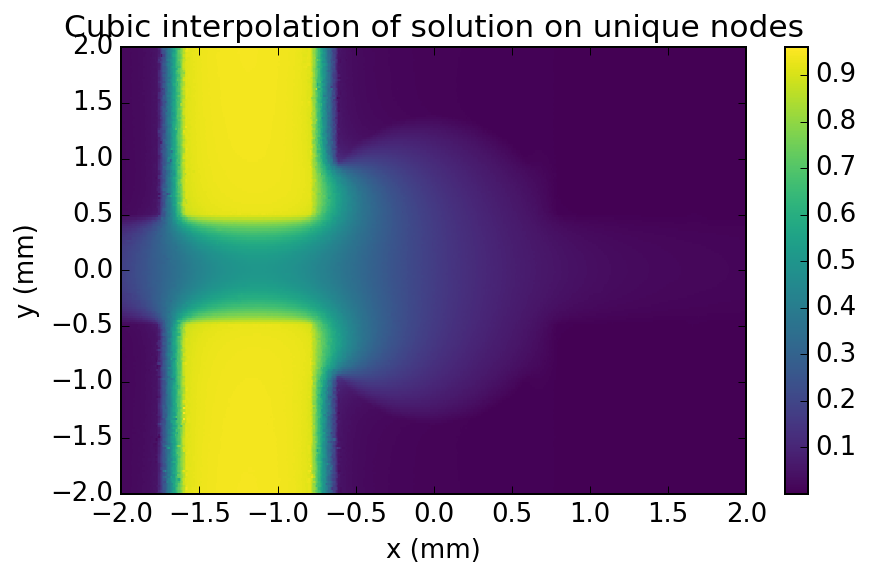

In [38]:
# Evaluate all files in the range
xeval=np.linspace(-2, 2, 501)
yeval = np.linspace(-2, 2, 201)

mother_path = r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch"

# datafiles = ["data/simulation/Maxwell/160528 - Trap area - fine mesh/0000 160528 - M016v5 trap xy (resonator) fine mesh.dsp",
#              "data/simulation/Maxwell/160528 - Trap area - fine mesh/0001 160528 - M016v5 trap xy (trap) fine mesh.dsp",
#              "data/simulation/Maxwell/160528 - Trap area - fine mesh/0002 160528 - M016v5 trap xyz (guardres) fine mesh.dsp",
#              "data/simulation/Maxwell/160528 - Trap area - fine mesh/0003 160528 - M016v5 trap xyz (guardcenter) fine mesh.dsp", 
#              "data/simulation/Maxwell/160528 - Trap area - fine mesh/0004 160528 - M016v5 trap xyz (guardtrap) fine mesh.dsp"]

datafiles = [r"Resonator.dsp", r""]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(7.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})

-0.0166666666667 -0.0166666666667 5.0 -5.0
(404,) (404,)
0.00221089003879
Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  =====================  =====================
Parameter            Value                   Std
===========  =====================  =====================
a0            0.26140049067367294    8.0292455890305e-06
a1           -0.003033512186318256  0.0008325716210731223
a2           -0.03766722107545055   0.015309475149898518
===========  =====================  =====================


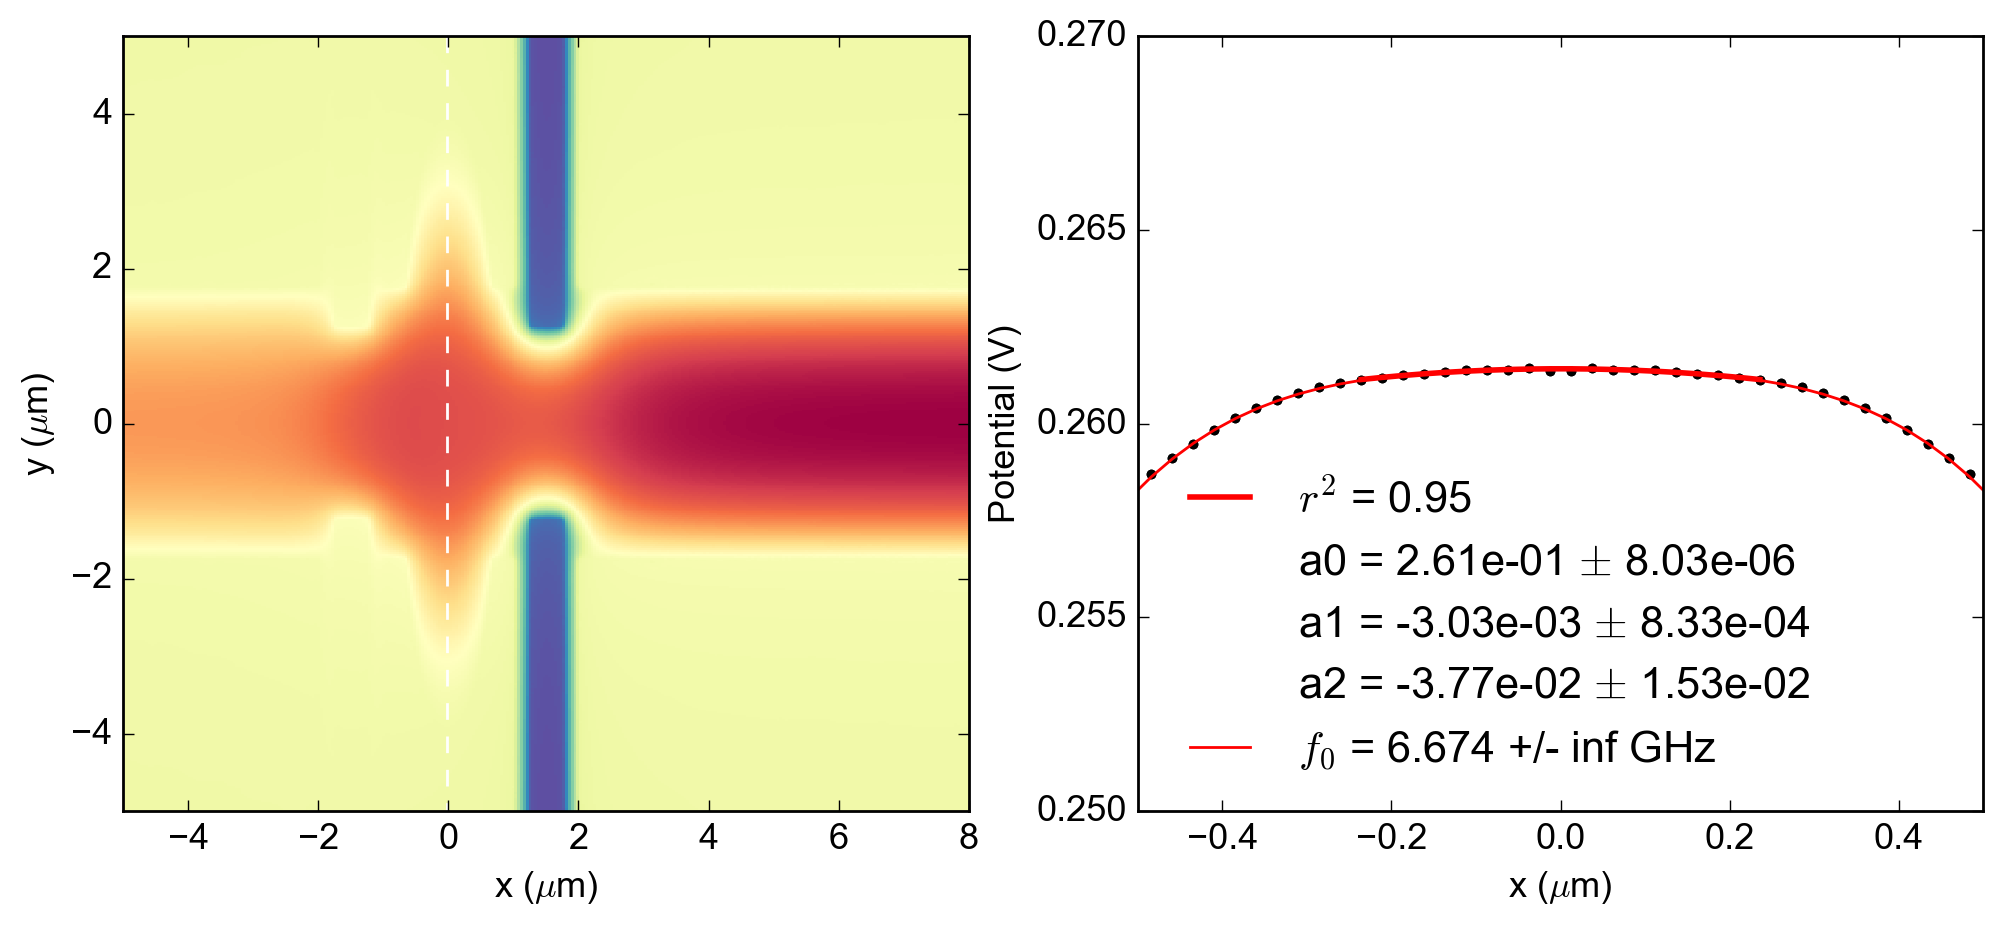

In [16]:
%matplotlib inline

#x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-2.0,2.0), ydomain=(-1.5, 1.5))
#import matplotlib as mpl
x = output[0]['x']
y = output[0]['y']

common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.60, trap=+0.30, resonatorguard=-0.30, trapguard=-0.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, fit_x = 0.0, 
                            resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
                            auto_scale=True):
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, trapguard]) * 10**scaling
    
    for k, coeff in enumerate(coefficients):
        if k == 0: 
            combined_potential = coeff * output[k]['V']
        else:
            combined_potential += coeff * output[k]['V']    
    
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.Spectral_r)
    
    if fit_potential_minimum:
        trap_xmin, trap_xmax = (-1.5, 1.5)
        trap_ymin, trap_ymax = (-3.0, 3.0)
        trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
        trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)
        
        print(trap_xmin_idx, trap_xmax_idx)
        print(trap_ymin_idx, trap_ymax_idx)
        
        yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                              ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
        yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
    else: 
        yidx = np.array([common.find_nearest(y[:,0], 0.0)])
        xidx = common.find_nearest(x[0,:], fit_x)
    
    plt1.plot([x[-1,xidx],x[0,xidx]], [y[-1,xidx], y[0,xidx]], '--', color='white')
    plt1.set_xlim(np.min(x), np.max(x))
    plt1.set_ylim(np.min(y), np.max(y))
    print(x[-1,xidx],x[0,xidx], y[-1,xidx], y[0,xidx])
    
    plt1.set_xlabel("x ($\mu$m)")
    plt1.set_ylabel("y ($\mu$m)")
    
    Vdata = combined_potential[:,xidx]
    xdata = y[:,xidx]
    plt2.plot(xdata, Vdata, '.k')
    
    print(np.shape(xdata), np.shape(Vdata))
    print(Vdata[0])
    
    
    fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=True)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    
    fr, ferr = kfit.fit_poly(xdata, Vdata, fitparams=[0, 1, 2], mode='even', domain=(-0.25, +0.25))
    plt2.plot(xdata, kfit.polyfunc_even(xdata, *fr), '-r', lw=1.0, label="$f_0$ = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    plt.legend(loc=0, frameon=False)
    plt2.set_ylim(color_minimum, color_maximum)
    plt2.set_xlim(-0.50, +0.50)
    plt2.set_xlabel("x ($\mu$m)")
    plt2.set_ylabel("Potential (V)")
    plt.gca().set_axis_bgcolor('none')
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    biasVoltages = "$V_{res}$ = %.3f\n$V_{trap}$ = %.3f\n$V_{rguard}$ = %.3f\n$V_{tguard}$ = %.3f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, trapguard * 10**scaling)
    
#     plt2.text(2, ymin + 0.1*(ymax-ymin), biasVoltages)
    plt.show()
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.001), color_maximum=(-5, 5, 0.001),
         fit_x = (-1, 6, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=False, 
         auto_scale=True);

# Curvature as a function of $V_\mathrm{rg}$ and $V_\mathrm{trap}$

In [210]:
%matplotlib inline
from tqdm import tqdm

#x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-2.0,2.0), ydomain=(-1.5, 1.5))
#import matplotlib as mpl
x = output[0]['x']
y = output[0]['y']

resonator = 0.80
Vtraps = np.arange(0.12, 0.605, 0.005)
Vresguards = np.arange(0.00, -0.81, -0.01)
trapguard = -0.00

mu = -0.370
fit_x = 0.5
fit_potential_minimum=True

efreqs = np.zeros((len(Vtraps), len(Vresguards)))
xposition = np.zeros((len(Vtraps), len(Vresguards)))
barrier_height = np.zeros((len(Vtraps), len(Vresguards)))
barrier_height_minus_trap = np.zeros((len(Vtraps), len(Vresguards)))
barrier_minus_mu = np.zeros((len(Vtraps), len(Vresguards)))
trap_level = np.zeros((len(Vtraps), len(Vresguards)))

for n, trap in tqdm(enumerate(Vtraps)):
    for m, resonatorguard in enumerate(Vresguards):    
        coefficients = np.array([resonator, trap, resonatorguard, trapguard])

        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V']
            else:
                combined_potential += coeff * output[k]['V']    

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.0)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-1, xidx+1 + 1, 1):
            Vdata = combined_potential[:,X]
            xdata = y[:,X]

            fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
            f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
            f0s.append(f0)
        
        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)
        
        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])
        
        efreqs[n,m] = np.mean(f0s)
        xposition[n,m] = x[0, xidx]
        barrier_height[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), barrier_min_idx:barrier_max_idx])
        barrier_height_minus_trap[n,m] = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        barrier_minus_mu[n,m] = np.max(-combined_potential[int(len(y[:,0])/2), barrier_min_idx:barrier_max_idx]) - mu
        trap_level[n,m] = -combined_potential[int(len(y[:,0])/2), trap_level_idx]
        
        

0it [00:00, ?it/s]/Users/gkoolstra/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/gkoolstra/Documents/Code/TrapAnalysis/trap_analysis.py:169: RuntimeWarning: invalid value encountered in sqrt
  f = 1/(2*np.pi) * np.sqrt(-c['e']*2*fr[1]*1E12/c['m_e'])
/Users/gkoolstra/Documents/Code/TrapAnalysis/trap_analysis.py:170: RuntimeWarning: invalid value encountered in sqrt
  sigma_f = 1/(4*np.pi) * np.sqrt(-2*c['e']*1E12/(fr[1]*c['m_e'])) * ferr[1]
97it [00:25,  3.73it/s]


0.835


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


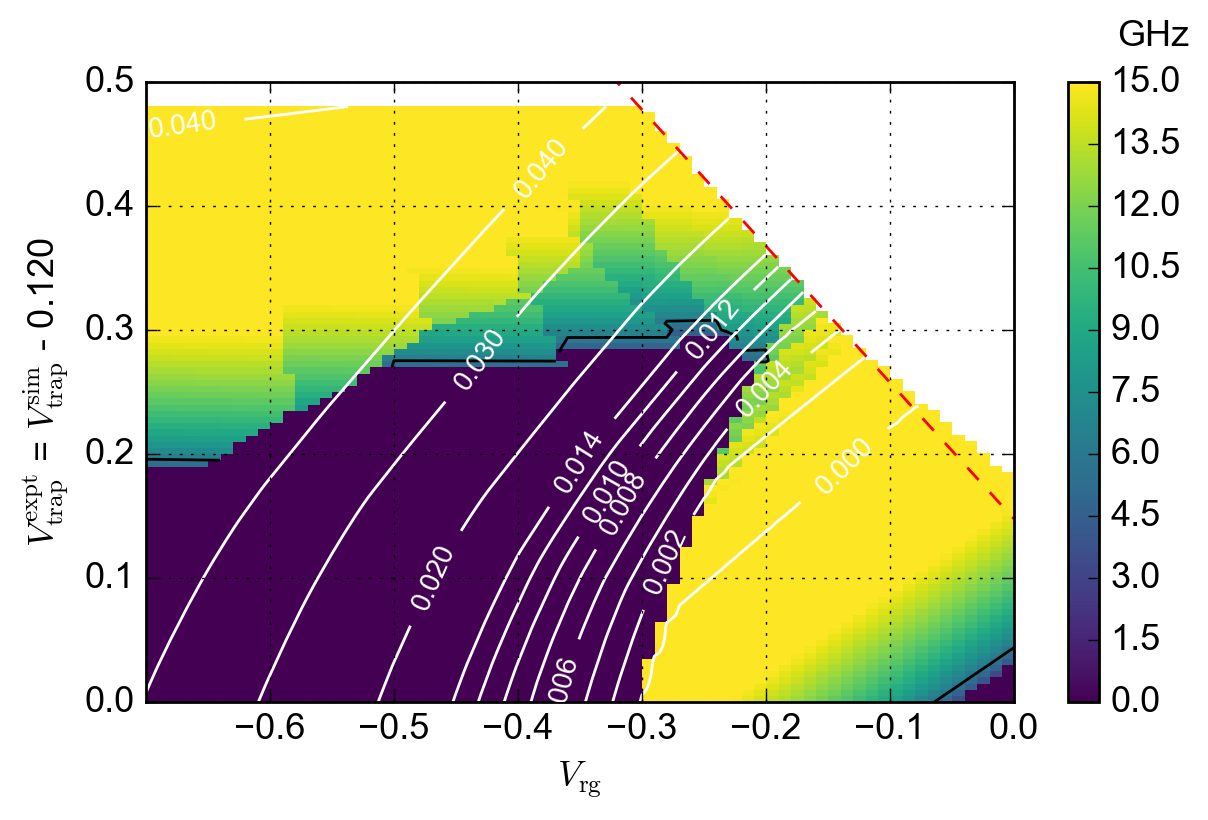

In [218]:
Em = ma.masked_where(barrier_minus_mu<0, efreqs/1E9)
Zm = ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap)
levels = np.arange(0, 0.016, 0.002).tolist() + np.arange(0.020, 0.050, 0.010).tolist()
# levels = np.arange(0,12,2)

fig=plt.figure(figsize=(7.,4.))
common.configure_axes(13)
plt.pcolormesh(Vresguards, Vtraps-0.120, Em, cmap=plt.cm.viridis, vmin=0, vmax=15)
cbar = plt.colorbar()
cbar.set_label("GHz", labelpad=-10, x=1.10, y=1.10, rotation=0)
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps)-0.120, np.max(Vtraps)-0.120)
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}^\mathrm{expt}$ = $V_\mathrm{trap}^\mathrm{sim}$ - 0.120")
# plt.title("Trap depth ($\mu$ = %.3f)"%mu)
plt.contour(Vresguards, Vtraps-0.120, efreqs/1E9, levels=[6.5], colors='k')

plt.grid()
x = np.linspace(-0.6, 0.0, 100)
plt.plot(x, Vtrap_expt(x, mu) + 0.120 - 0.120, '--', color='red')
plt.plot(x, Vtrap_th_expt(x, mu) + 0.120 - 0.120, '--', color='red')
# plt.plot(x, 0.25*x+0.4)
# plt.plot(x, 0.42 + 1.17*x, '--', color='gray')
CS = plt.contour(Vresguards, Vtraps-0.120, Zm, colors='white', levels=levels)
# CS = plt.contour(Vresguards, Vtraps-0.120, Em, colors='white', levels=levels)
plt.clabel(CS, colors='white', inline=1, fontsize=10)
# plt.text(-0.25, 0.5, "Unstable", fontsize=13, color='red')
# plt.plot(x, Vtrap_IsoBarrier_expt(x, contour=0.010) + 0.120, '--', color='deeppink')

# def f_mu(mu):
#     return -1.755 -7*mu

def f_mu(mu):
    return 7.375*(mu+0.35)


plt.xlim(-0.7, 0.0)
plt.ylim(0.00, 0.50)

plt.plot(x, -1.10*x - f_mu(mu), '--', color='red')

# Vtrap_park = 0.150
# Vtrap_stop = 0.250
# x = 0.15
# Vrg_start = -1/1.15*(Vtrap_park - (f_mu(mu)-0.120))-x
# Vrg_stop = -1/1.15*(Vtrap_stop - (f_mu(mu)-0.120))-x

# plt.plot([0, Vrg_start, Vrg_stop], [Vtrap_park+0.120, Vtrap_park+0.120, Vtrap_stop+0.120], '-', color='r')

# common.save_figure(fig, save_path=r"/Volumes/slab-1/_Data/170422 - EonHe M018V6 with L3 etch/data/170711")

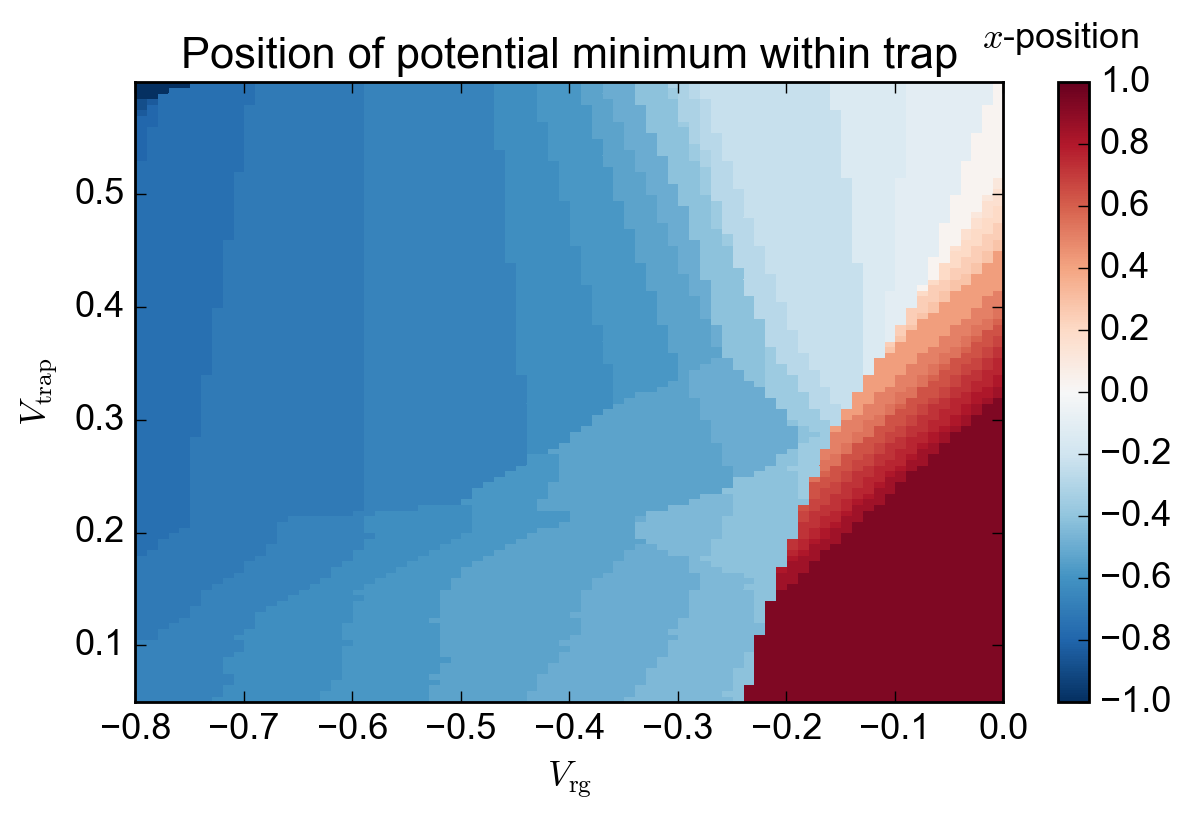

In [262]:
fig = plt.figure(figsize=(7.,4.))
common.configure_axes(13)
plt.pcolormesh(Vresguards, Vtraps, xposition,cmap=plt.cm.RdBu_r, vmin=-1.0, vmax=+1.0)
cbar = plt.colorbar()
cbar.set_label("$x$-position", labelpad=-40, x=1.10, y=1.10, rotation=0)
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("Position of potential minimum within trap")

# rg_sweep = np.arange(-0.50, -0.30, +0.01)
# t_sweep = 0.120 + np.arange(0.25, 0.10, -0.01)
# plt.plot([0.00, -0.5], [0.25+0.120, 0.25+0.120], color=rgba(0, len(rg_sweep)+1))
# for i, v in enumerate(rg_sweep):
#     plt.plot([v, v], [t_sweep[0], t_sweep[-1]],  
#              '-o', mec='none', color=rgba(i, len(rg_sweep)+1))    

# common.save_figure(fig, save_path=r"/Volumes/slab-1/_Data/170422 - EonHe M018V6 with L3 etch/data/170711")

Fit function: y = a0 + a1*x + a2*x**3 + ...
===========  =====================  ===================
Parameter            Value                  Std
===========  =====================  ===================
a0           -0.016571426748030242  0.02586740459599574
a1            -1.742857135877665    0.09897433488729707
===========  =====================  ===================


(0.0, 0.5)

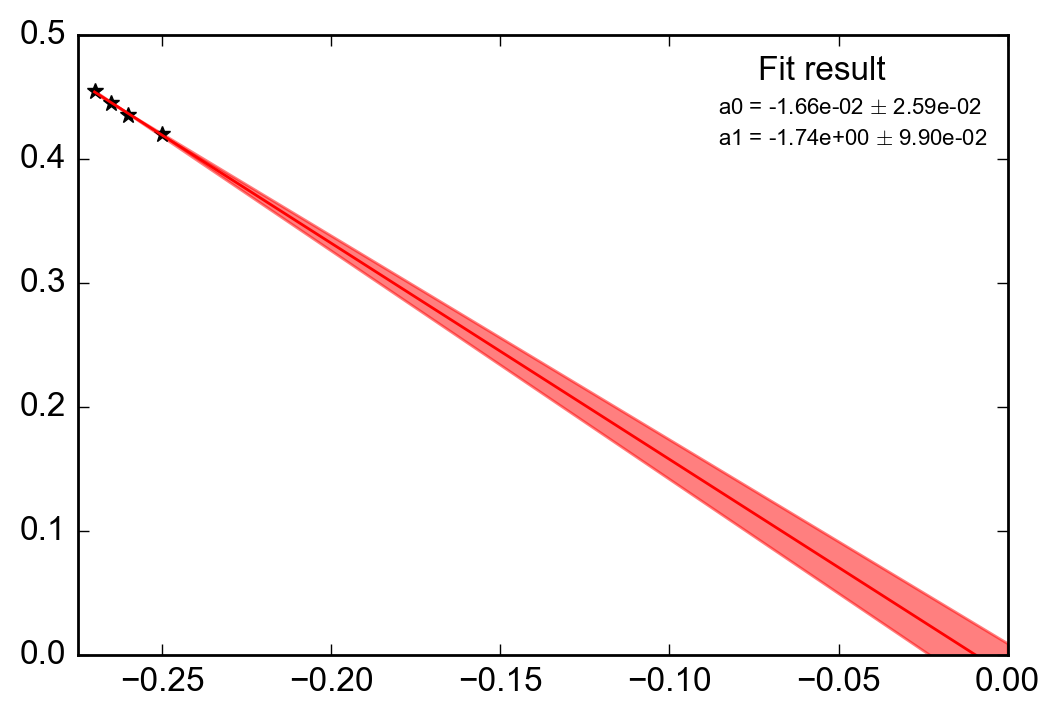

In [57]:
plt.figure()
common.configure_axes(12)
xs = np.array([-0.26, -0.265, -0.27, -0.25])
ys = np.array([0.315, 0.325, 0.335, 0.300]) + 0.120
fr, ferr = kfit.fit_poly(xs, ys, fitparams=[0, 1])
plt.plot(xs, ys, '*k')
xplots = np.linspace(-0.27, 0, 100)
plt.plot(xplots, kfit.polyfunc(xplots, *fr))
plt.fill_between(xplots, kfit.polyfunc(xplots, *fr+ferr), y2=kfit.polyfunc(xplots, *fr-ferr), alpha=0.5, color='r')
plt.xlim(-0.275, 0.000)
plt.ylim(0.0, 0.50)

In [9]:
def Vtrap_expt(Vrg, mu):
    f_mu = -1.755-7*mu
    print(f_mu)
    return (f_mu-0.120) - 1.15*Vrg

def Vtrap_th_expt(Vrg, mu):
    return (-0.120 - 1.69 * mu)*np.ones(len(Vrg))

def Vtrap_IsoBarrier_expt(Vrg, contour):
    return 0.32 + 10 * contour + 1.15 * Vrg

def Vrg_IsoBarrier_expt(Vtrap, contour):
    return 1/1.15 * (Vtrap - 0.32 - 10 * contour)

In [10]:
import matplotlib
def rgba(i, N):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    cmap = plt.cm.plasma
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

0.9750000000000001


(0.12, 0.60000000000000042)

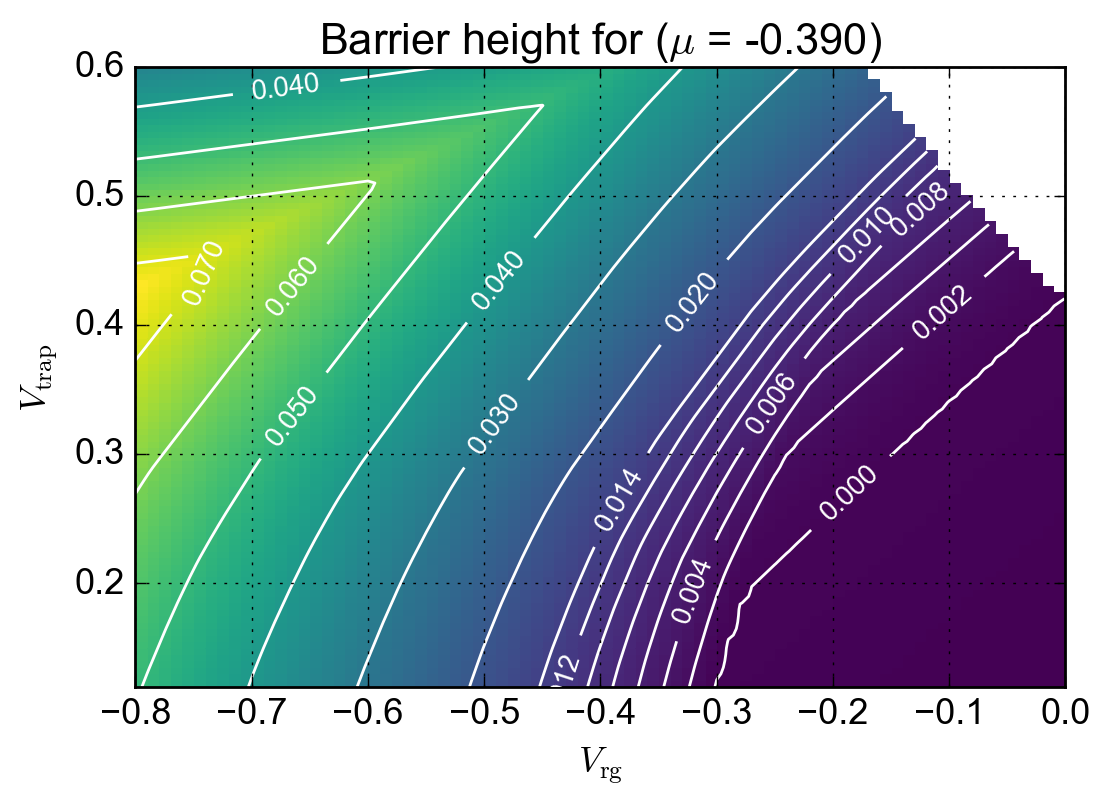

In [209]:
Zm = ma.masked_where(barrier_minus_mu<0, barrier_height_minus_trap)
levels = np.arange(0, 0.016, 0.002).tolist() + np.arange(0.020, 0.090, 0.010).tolist()

fig = plt.figure(figsize=(6.,4.))
common.configure_axes(13)
plt.pcolormesh(Vresguards, Vtraps, Zm, cmap=plt.cm.viridis)
CS = plt.contour(Vresguards, Vtraps, Zm, colors='white', levels=levels)
plt.clabel(CS, colors='white', inline=1, fontsize=10)
cbar.set_label("eV", labelpad=-40, x=1.10, y=1.10, rotation=0)
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("Barrier height for ($\mu$ = %.3f)"%(mu))

dV = 0.05
vrg_isolate = np.arange(-0.300, -0.500, -dV)
vtrap_park = 0.1800 + 0.120
vtrap_unload_stop = [0.120 + 0.120 - i*dV/2. for i in range(len(vrg_isolate))]
slope = 1

# for i, v in enumerate(vrg_isolate):
#     plt.plot([0.00, v, v - slope*(vtrap_unload_stop[i]-vtrap_park), 0.00], 
#              [vtrap_park, vtrap_park, vtrap_unload_stop[i], vtrap_unload_stop[i]], 
#              '-o', mec='none', color=rgba(i, len(vrg_isolate)))    
    
#     if i == 3:
#         print("From (Vrg_isolate, Vtrap_park) = ", (v, vtrap_park-0.120), "\nTo (Vrg_isolate_stop, Vtrap_unload_stop) = ", (v - slope*(vtrap_unload_stop[i]-vtrap_park), vtrap_unload_stop[i]-0.120))

plt.grid()
x = np.linspace(-0.6, 0.0, 100)
plt.plot(x, Vtrap_expt(x, mu) + 0.120, '--', color='red')
plt.plot(x, Vtrap_th_expt(x, mu) + 0.120, '--', color='red')
# plt.plot(x, 0.42 + 1.15*x, '--', color='gray')

# plt.plot(x, Vtrap_IsoBarrier_expt(x, contour=0.04) + 0.120, '--', color='deeppink')

plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))

# common.save_figure(fig, save_path=r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170712")

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


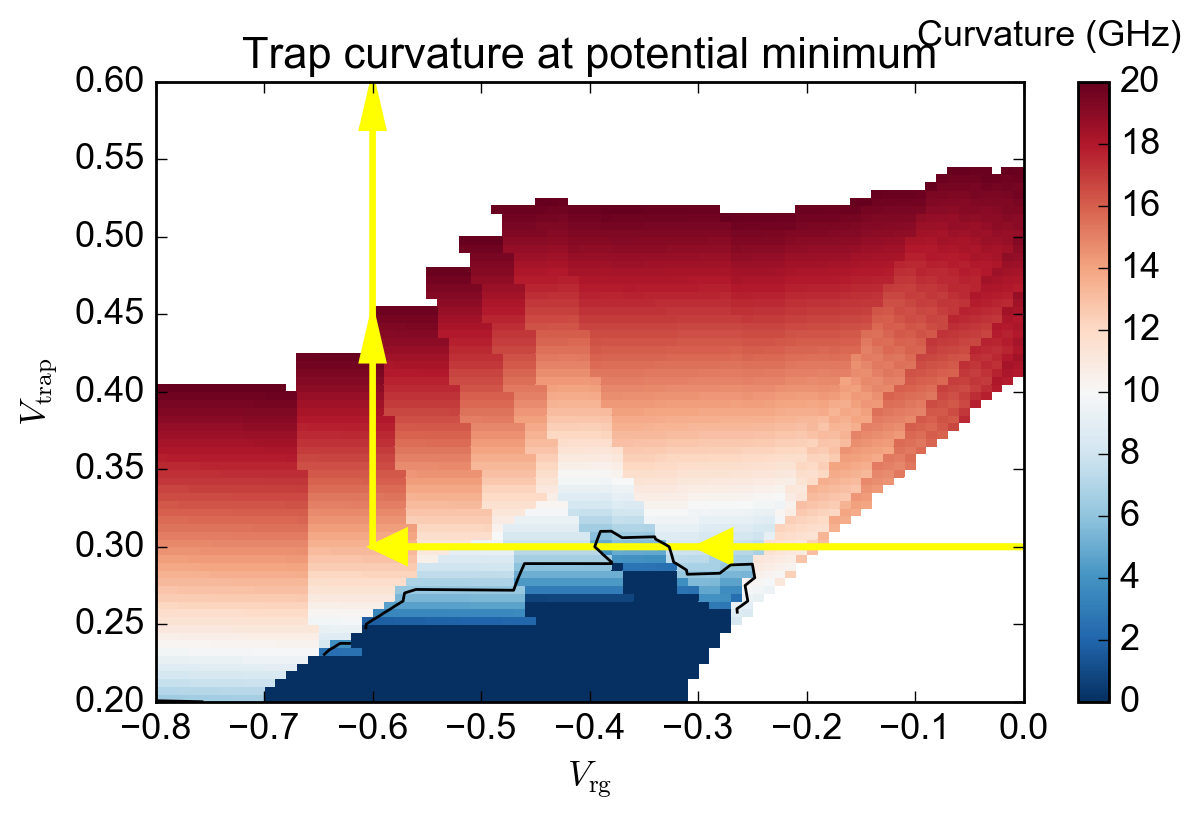

In [12]:
import numpy.ma as ma

Zm = ma.masked_where(np.logical_or(-barrier_height<0.001, efreqs/1E9>20), efreqs/1E9)

fig=plt.figure(figsize=(7.,4.))
common.configure_axes(13)
plt.pcolormesh(Vresguards, Vtraps, Zm, vmin=0, vmax=20, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar()
cbar.set_label("Curvature (GHz)", labelpad=-40, x=1.10, y=1.10, rotation=0)
plt.xlim(np.min(Vresguards), np.max(Vresguards))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.xlabel("$V_\mathrm{rg}$")
plt.ylabel("$V_\mathrm{trap}$")
plt.title("Trap curvature at potential minimum")
plt.contour(Vresguards, Vtraps, efreqs/1E9, levels=[6.5], colors='k')

# common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

# Evaluate trap curvature along arbitrary ($V_\mathrm{rg}, V_\mathrm{trap}$)

In [145]:
def eval_freq_along_line(Vrg, Vtrap):
    x = output[0]['x']
    y = output[0]['y']

    Vress = 0.60*np.ones(len(Vrg))
    Vtrapguards = np.zeros(len(Vrg)) 

    fit_potential_minimum=True

    efreqs = []
    xposition = []
    barrier_heights = []

    for n, coefficients in enumerate(zip(Vress, Vtrap, Vrg, Vtrapguards)):  
        for k, coeff in enumerate(coefficients):
            if k == 0: 
                combined_potential = coeff * output[k]['V']
            else:
                combined_potential += coeff * output[k]['V']    

        if fit_potential_minimum:
            trap_xmin, trap_xmax = (-1.5, 1.5)
            trap_ymin, trap_ymax = (-3.0, 3.0)
            trap_xmin_idx, trap_xmax_idx = common.find_nearest(x[0,:], trap_xmin), common.find_nearest(x[0,:], trap_xmax)
            trap_ymin_idx, trap_ymax_idx = common.find_nearest(y[:,0], trap_ymin), common.find_nearest(y[:,0], trap_ymax)

            yidx, xidx = np.where(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]\
                                  ==np.max(combined_potential[trap_ymin_idx:trap_ymax_idx, trap_xmin_idx:trap_xmax_idx]))
            yidx, xidx = yidx[1]+trap_ymin_idx, xidx[1]+trap_xmin_idx
        else: 
            yidx = np.array([common.find_nearest(y[:,0], 0.0)])
            xidx = common.find_nearest(x[0,:], fit_x)

        f0s = list()
        # Average f0 one index around the fit_x or potential minimum.
        for X in np.arange(xidx-2, xidx+2 + 1, 1):
            Vdata = combined_potential[:,X]
            xdata = y[:,X]

            fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
            f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
            f0s.append(f0)
        
        efreqs.append(np.mean(f0s))
        xposition.append(x[0, xidx])
        
        res_barrier = (1.0, 2.0)
        res_barrier_min_idx = common.find_nearest(x[0,:], res_barrier[0])
        res_barrier_max_idx = common.find_nearest(x[0,:], res_barrier[1])
        trap_level_idx = common.find_nearest(x[0,:], -5.0)
        
        trap_barrier = (-2.5, -1.0)
        trap_barrier_min_idx = common.find_nearest(x[0,:], trap_barrier[0])
        trap_barrier_max_idx = common.find_nearest(x[0,:], trap_barrier[1])
        
        barrier_height_minus_trap = np.min([np.max(-combined_potential[int(len(y[:,0])/2), res_barrier_min_idx:res_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx], 
                                                np.max(-combined_potential[int(len(y[:,0])/2), trap_barrier_min_idx:trap_barrier_max_idx]) \
                                         + combined_potential[yidx, xidx]])
        
        barrier_heights.append(barrier_height_minus_trap)
        
    return np.array(efreqs), np.array(xposition), np.array(barrier_heights)

Load voltage axes (experimental data) from file.

In [163]:
def f_mu(mu_guess):
    return -1.755-7*mu_guess

sub_dir = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170813/170813_102805_diagonal_sweep_also_up"

with h5py.File(os.path.join(sub_dir, os.path.split(sub_dir)[1]+".h5"), "r") as f:
    Vrgs = f["sweep_voltage_1"][()]
    Vtraps = f["sweep_voltage_2"][()]

Ef = []
Xposs = []
BH = []
for k in tqdm(range(np.shape(Vrgs)[0])):
    ef, xpos, barheight = eval_freq_along_line(Vrgs[k,:], Vtraps[k,:]+0.120)
    Ef.append(ef)
    Xposs.append(xpos)
    BH.append(barheight)

  0%|          | 0/64 [00:00<?, ?it/s]/Users/gkoolstra/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/gkoolstra/Documents/Code/TrapAnalysis/trap_analysis.py:169: RuntimeWarning: invalid value encountered in sqrt
  f = 1/(2*np.pi) * np.sqrt(-c['e']*2*fr[1]*1E12/c['m_e'])
/Users/gkoolstra/Documents/Code/TrapAnalysis/trap_analysis.py:170: RuntimeWarning: invalid value encountered in sqrt
  sigma_f = 1/(4*np.pi) * np.sqrt(-2*c['e']*1E12/(fr[1]*c['m_e'])) * ferr[1]
100%|██████████| 64/64 [02:13<00:00,  2.32s/it]


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


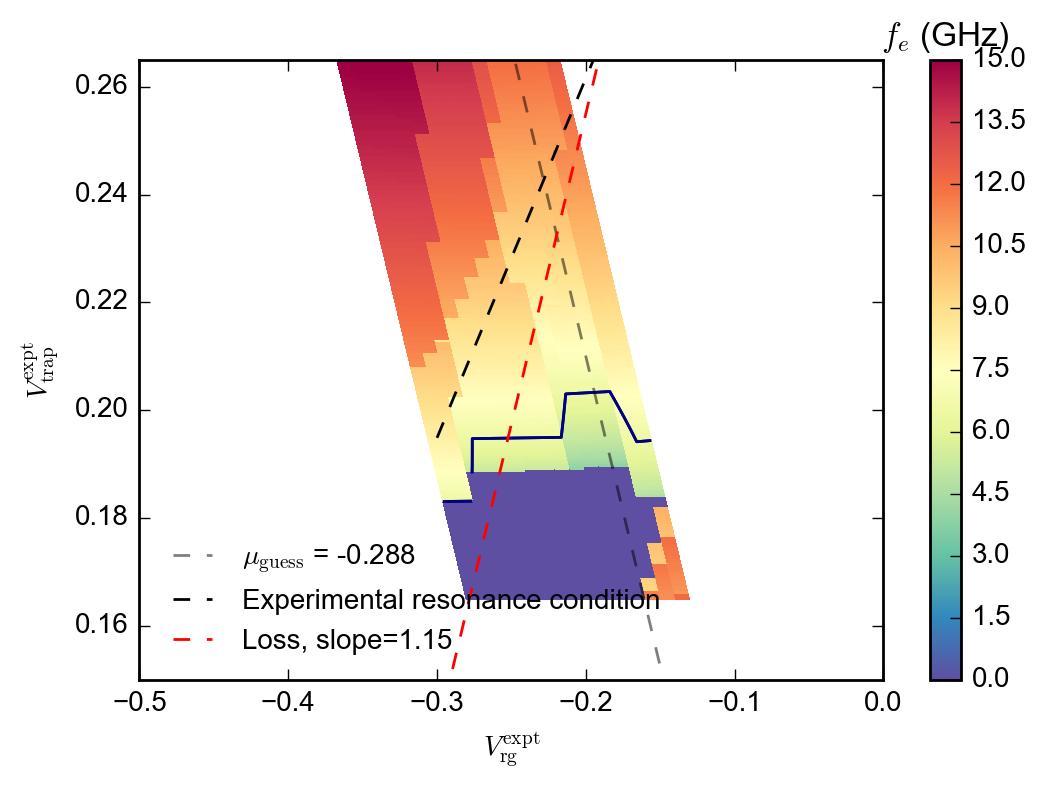

In [175]:
plt.pcolormesh(Vrgs, Vtraps, np.array(Ef)/1E9, cmap=plt.cm.Spectral_r, vmin=0, vmax=15)
cbar = plt.colorbar()
plt.contour(Vrgs, Vtraps, np.array(Ef)/1E9, levels=[6.5])
cbar.ax.set_title("$f_e$ (GHz)", size=12)

rg = np.linspace(-0.30, 0.00)
plt.plot(rg, f_mu(-0.265)-0.120 - 1.15*rg, '--', color='k', label="$\mu_\mathrm{guess}$ = %.3f"%mu, alpha=0.5)
plt.plot(rg, 0.667*rg+0.395, '--k', label=r"Experimental resonance condition")
plt.plot(rg, 1.15*rg+0.485, '--r', label=r"Loss, slope=1.15")

plt.ylabel("$V_\mathrm{trap}^\mathrm{expt}$")
plt.xlabel("$V_\mathrm{rg}^\mathrm{expt}$")
plt.xlim(-0.5, -0.00)
plt.ylim(0.15, 0.265)
plt.legend(loc=0, prop={'size' : 10}, frameon=False)

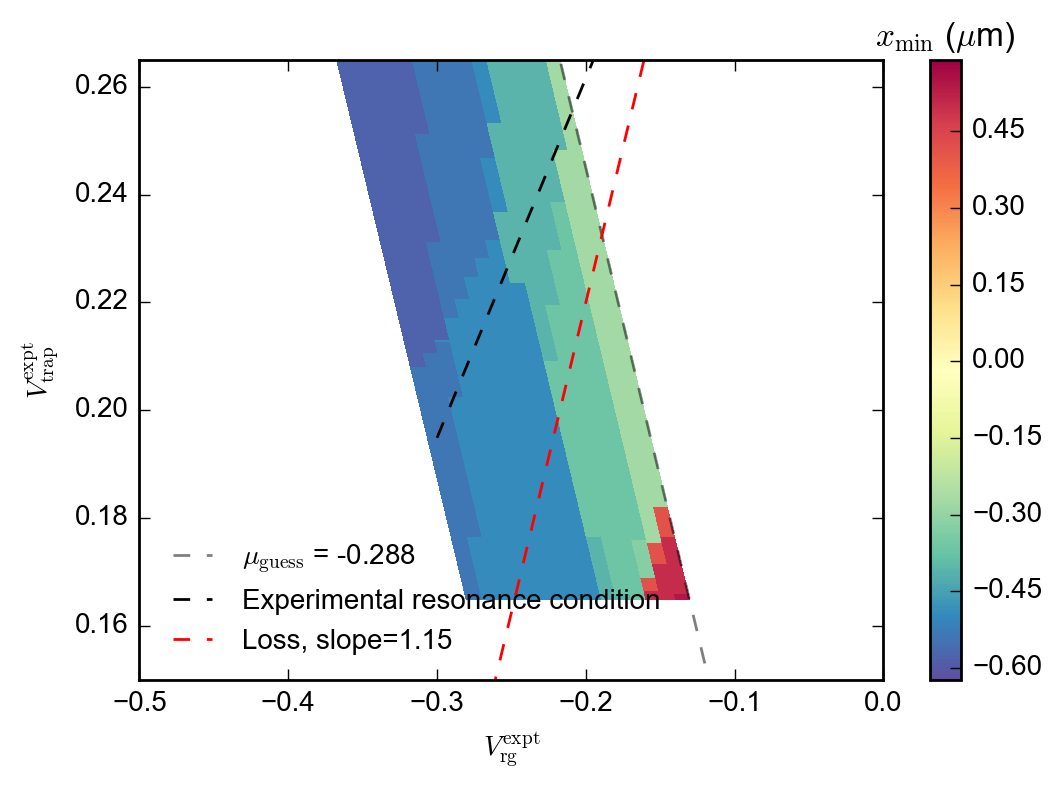

In [176]:
plt.pcolormesh(Vrgs, Vtraps, np.array(Xposs), cmap=plt.cm.Spectral_r)
cbar = plt.colorbar()
cbar.ax.set_title("$x_\mathrm{min}$ ($\mu$m)", size=12)

rg = np.linspace(-0.30, 0.00)
plt.plot(rg, f_mu(-0.270)-0.120 - 1.15*rg, '--', color='k', label="$\mu_\mathrm{guess}$ = %.3f"%mu, alpha=0.5)
plt.plot(rg, 0.667*rg+0.395, '--k', label=r"Experimental resonance condition")
plt.plot(rg, 1.15*rg+0.45, '--r', label=r"Loss, slope=1.15")

plt.ylabel("$V_\mathrm{trap}^\mathrm{expt}$")
plt.xlabel("$V_\mathrm{rg}^\mathrm{expt}$")
plt.xlim(-0.5, -0.00)
plt.ylim(0.15, 0.265)
plt.legend(loc=0, prop={'size' : 10}, frameon=False)

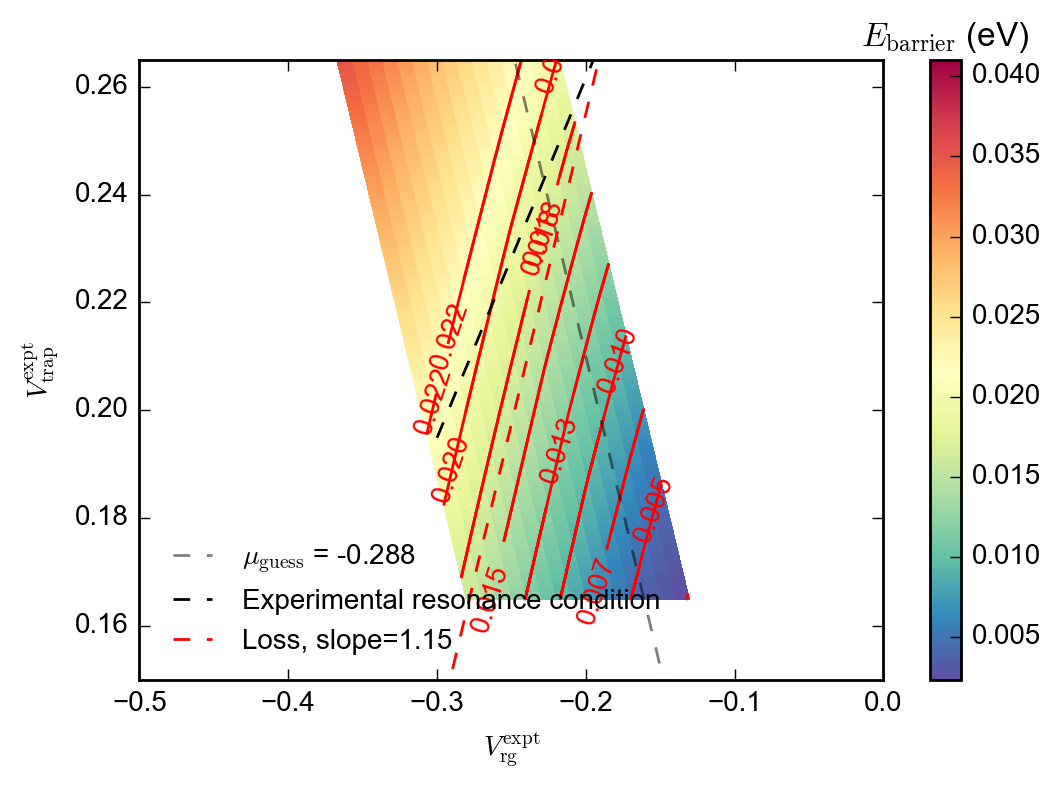

In [177]:
plt.pcolormesh(Vrgs, Vtraps, np.array(BH), cmap=plt.cm.Spectral_r)
cbar = plt.colorbar()
CS = plt.contour(Vrgs, Vtraps, np.array(BH), levels=np.arange(0, 0.025, 0.0025), colors='r')
plt.clabel(CS, colors='red', inline=1, fontsize=10)

cbar.ax.set_title("$E_\mathrm{barrier}$ (eV)", size=12)

rg = np.linspace(-0.30, 0.00)
plt.plot(rg, f_mu(-0.265)-0.120 - 1.15*rg, '--', color='k', label="$\mu_\mathrm{guess}$ = %.3f"%mu, alpha=0.5)
plt.plot(rg, 0.667*rg+0.395, '--k', label=r"Experimental resonance condition")
plt.plot(rg, 1.15*rg+0.485, '--r', label=r"Loss, slope=1.15")

plt.ylabel("$V_\mathrm{trap}^\mathrm{expt}$")
plt.xlabel("$V_\mathrm{rg}^\mathrm{expt}$")
plt.xlim(-0.5, -0.00)
plt.ylim(0.15, 0.265)
plt.legend(loc=0, prop={'size' : 10}, frameon=False)

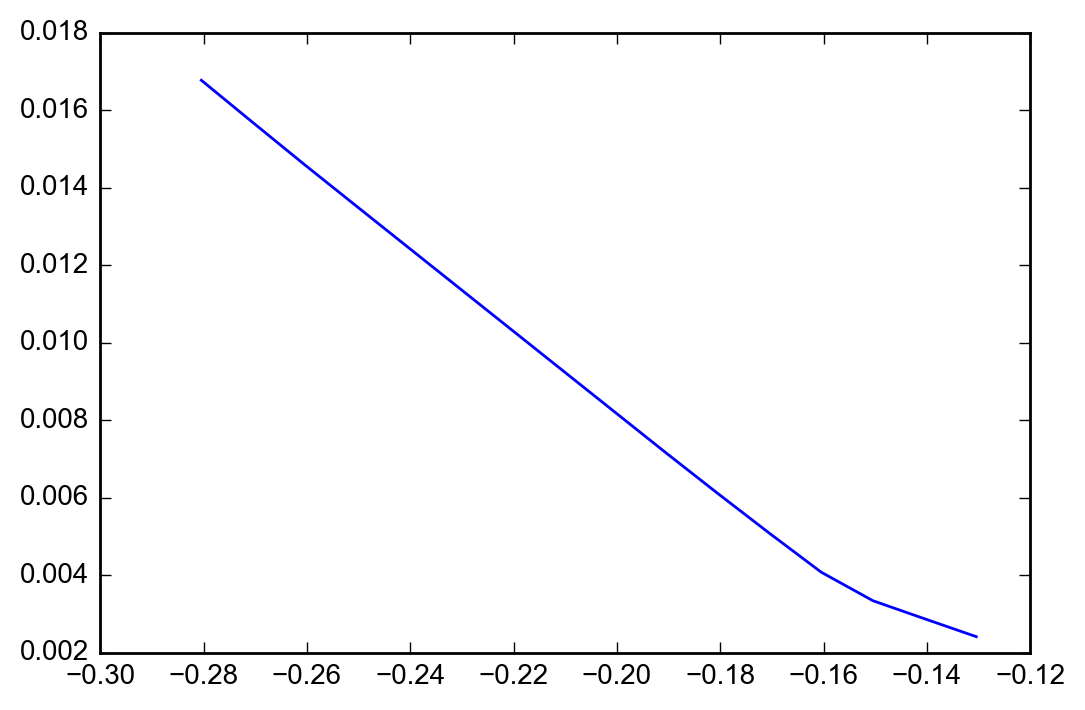

In [178]:
plt.plot(Vrgs[:, 250], np.array(BH)[:,250])